<a href="https://colab.research.google.com/github/dtnam302/NLP/blob/main/NLP_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Download data

In [ ]:
!gdown --id 1db6p7dTCgSuGnD7vDMFAKLfIzk87p5wB
!gdown --id 156Ia8mnr_DpeiX5LQXRD9odEJWIEncP8
!gdown --id 1voYpq3nsVlXy_6H_v1EjoS0G1CA6SrLu
!gdown --id 11ahBX0_uzLBF1NRsMxZzljJyR3xACKsT

Downloading...
From: https://drive.google.com/uc?id=1db6p7dTCgSuGnD7vDMFAKLfIzk87p5wB
To: /content/vlsp_sentiment_test.csv
100% 159k/159k [00:00<00:00, 58.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=156Ia8mnr_DpeiX5LQXRD9odEJWIEncP8
To: /content/vlsp_sentiment_train.csv
100% 858k/858k [00:00<00:00, 56.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1voYpq3nsVlXy_6H_v1EjoS0G1CA6SrLu
To: /content/vi-model-CBOW.bin
100% 699M/699M [00:08<00:00, 81.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=11ahBX0_uzLBF1NRsMxZzljJyR3xACKsT
To: /content/vietnamese-stopwords-dash.txt
100% 20.5k/20.5k [00:00<00:00, 19.0MB/s]


##Import library

In [ ]:
!pip install gensim

In [ ]:
!pip install pyvi

     |████████████████████████████████| 8.5 MB 4.2 MB/s 
     |████████████████████████████████| 743 kB 54.2 MB/s 


In [ ]:
import tensorflow as tf
import pandas as pd 
import numpy as np
from string import digits
from collections import Counter
from pyvi import ViTokenizer
from gensim.models.word2vec import Word2Vec
from keras.utils.np_utils import to_categorical
%matplotlib inline
import seaborn as sns

##Preprocessing

In [ ]:
data_train = pd.read_csv("vlsp_sentiment_train.csv", sep='\t')
data_train.columns =['Class', 'Data']
data_test = pd.read_csv("vlsp_sentiment_test.csv", sep='\t')
data_test.columns =['Class', 'Data']

In [ ]:
print(data_train.shape)
print(data_test.shape)

(5100, 2)
(1050, 2)


In [ ]:
data_train.head(10)

,Class,Data
0,-1,"Mình đã dùng anywhere thế hệ đầu, quả là đầy t..."
1,-1,"Quan tâm nhất là độ trễ có cao không, dùng thi..."
2,-1,"dag xài con cùi bắp 98k....pin trâu, mỗi tội đ..."
3,-1,logitech chắc hàng phải tiền triệu trở lên dùn...
4,-1,"Đang xài con m175 cùi mía , nhà xài nhiều chuộ..."
5,-1,"Đang xài 2 con M185, nút chuột giữa hai con đề..."
6,-1,Con Anywhere 1 mình dùng bị double click cũng ...
7,-1,"Hàng cty cấp, cấp xong vứt ở nhà, xài con Xorn..."
8,-1,"Magic mouse mà ngon hơn mới lạ, Magic mouse ch..."
9,-1,"em giống y bác luôn, chán bluetooth kinh hồn, ..."


In [ ]:
data_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Class,5100.0,0.0,0.816577,-1.0,-1.0,0.0,1.0,1.0


In [ ]:
data_train.isnull().sum()

Class    0
Data     0
dtype: int64

In [ ]:
labels = data_train.iloc[:, 0].values
reviews = data_train.iloc[:, 1].values

In [ ]:
encoded_labels = []

for label in labels:
    if label == -1:
        encoded_labels.append([1,0,0])
    elif label == 0:
        encoded_labels.append([0,1,0])
    else:
        encoded_labels.append([0,0,1])

encoded_labels = np.array(encoded_labels)  

###Define some preprocess function


In [ ]:
import re

In [ ]:
def text_preprocess(document):
    # tách từ
    document = ViTokenizer.tokenize(document.lower())
    # xóa các ký tự không cần thiết
    document = re.sub(r'[^\s\wáàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ_]',' ',document)
    # xóa khoảng trắng thừa
    document = re.sub(r'\s+', ' ', document).strip()
    return document

###Preprocessing 


In [ ]:
# reviews_processed = []
# unlabeled_processed = [] 
# for review in reviews:
#     review_cool_one = ''.join([char for char in review if char not in digits])
#     reviews_processed.append(review_cool_one)

In [ ]:
#Use PyVi for Vietnamese word tokenizer
word_reviews = []
all_words = []
for review in reviews:
    review = ''.join([char for char in review if char not in digits])
    review = text_preprocess(review)
    #review = ViTokenizer.tokenize(review.lower())
    word_reviews.append(review.split())


In [ ]:
print(reviews[2])
print(word_reviews[2])

dag xài con cùi bắp 98k....pin trâu, mỗi tội đánh liên minh ức chế đập hết 2 con
['dag', 'xài', 'con', 'cùi', 'bắp', 'k', 'pin', 'trâu', 'mỗi', 'tội', 'đánh', 'liên_minh', 'ức_chế', 'đập', 'hết', 'con']


##EDA

In [ ]:
word_reviews[11]

['mình',
 'đã',
 'lên',
 'nhưng',
 'vẫn',
 'bị',
 'đúng',
 'là',
 'tắt',
 'wifi',
 'đi',
 'thì',
 'ngon',
 'hơn',
 'hẵn',
 'chán',
 'vãi',
 'mua',
 'em',
 'noá',
 'để',
 'khỏi',
 'dùng',
 'usb',
 'receiver',
 'mà',
 'thấy',
 'cái',
 'bluetooth',
 'nản',
 'vãi']

In [ ]:
#clean_reviews[:2]

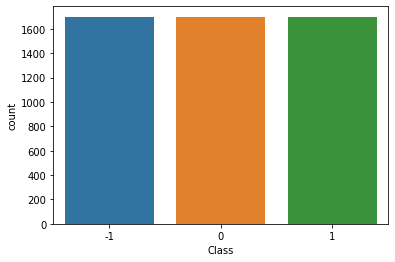

In [ ]:
ax = sns.countplot(x='Class', data=data_train)

In [ ]:
lenght = [len(word) for word in word_reviews]

In [ ]:
df = pd.DataFrame()

In [ ]:
df['len'] = lenght

In [ ]:
df.head()

,len
0,22
1,53
2,16
3,33
4,64


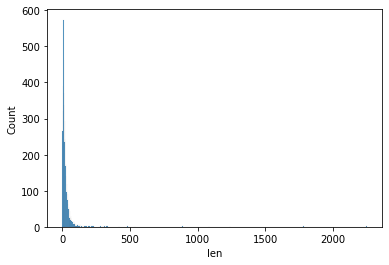

In [ ]:
ax = sns.histplot(x='len', data=df)

In [ ]:
df.describe()

,len
count,5100.000000
mean,25.322941
std,54.989698
min,1.000000
25%,9.000000
50%,16.000000
75%,29.000000
max,2249.000000


In [ ]:
df[df['len']>100].count()

len    100
dtype: int64

In [ ]:
df[df['len']<=100].count()

len    5000
dtype: int64

##New CBOW

In [ ]:
# from gensim.models import Word2Vec

# w2v_model = Word2Vec(word_reviews, min_count = 1, size = 400, window = 5, sg = 0)
# w2v_model.build_vocab(word_reviews,update = True)

# w2v_model.train(word_reviews, total_examples = w2v_model.corpus_count, epochs = 1000)
# w2v_model.wv.save('vi-model-CBOW-new.bin')

In [ ]:
#len(w2v_model.wv.vocab)

7893

##Training & Evaluating

###Embedding Layer

In [ ]:
EMBEDDING_DIM = 400 # how big is each word vector
MAX_VOCAB_SIZE = 10000 # how many unique words to use (i.e num rows in embedding vector)
MAX_SEQUENCE_LENGTH = 300 # max number of words in a comment to use

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [ ]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, lower=True, char_level=False)
tokenizer.fit_on_texts(word_reviews)
sequences_train = tokenizer.texts_to_sequences(word_reviews)
word_index = tokenizer.word_index


In [ ]:
len(word_index)

7893

In [ ]:
data = pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_LENGTH)
labels = encoded_labels

In [ ]:
print('Shape of X train and X validation tensor:',data.shape)
print('Shape of label train and validation tensor:', labels.shape)

Shape of X train and X validation tensor: (5100, 300)
Shape of label train and validation tensor: (5100, 3)


In [ ]:
def scheduler(epoch, lr):
  return lr * tf.math.exp(-0.1)

In [ ]:
#!cp '/content/drive/MyDrive/Colab Notebooks/Report/vi-model-CBOW-new.bin' '/content'

In [ ]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from gensim.models.keyedvectors import KeyedVectors

word_vectors = KeyedVectors.load_word2vec_format('vi-model-CBOW.bin',binary=True)
#word_vectors = KeyedVectors.load('vi-model-CBOW-new.bin')

vocabulary_size=min(len(word_index)+1,MAX_VOCAB_SIZE)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
miss = 0
for word, i in word_index.items():
    if i>=MAX_VOCAB_SIZE:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        miss+=1
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

del(word_vectors)
print(miss,vocabulary_size)

from keras.layers import Embedding
embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=True)

1153 7894


In [ ]:
#word_vectors = KeyedVectors.load_word2vec_format('vi-model-CBOW.bin', binary=True)

In [ ]:
#word_vectors.similar_by_word('bực_bội')

###Data test preprocessing

In [ ]:
labels_test = data_test.iloc[:, 0].values
reviews_test = data_test.iloc[:, 1].values

In [ ]:
len(reviews_test)

1050

In [ ]:
encoded_labels_test = []

for label_test in labels_test:
    if label_test == -1:
        encoded_labels_test.append([1,0,0])
    elif label_test == 0:
        encoded_labels_test.append([0,1,0])
    else:
        encoded_labels_test.append([0,0,1])

encoded_labels_test = np.array(encoded_labels_test)  

In [ ]:
word_reviews_test = []
for review in reviews_test:
    review = text_preprocess(review)
    word_reviews_test.append(review.split())

In [ ]:
sequences_test = tokenizer.texts_to_sequences(word_reviews_test)
datas_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
labels_test = encoded_labels_test

In [ ]:
print('Shape of X train and X validation tensor:',datas_test.shape)
print('Shape of label train and validation tensor:', labels_test.shape)

Shape of X train and X validation tensor: (1050, 100)
Shape of label train and validation tensor: (1050, 3)


###CNN - 69.43%

In [ ]:
from keras.layers import Dense, Input, GlobalMaxPooling1D,BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Conv2D, Dropout,concatenate,Conv1D, MaxPool1D,MaxPooling2D, Bidirectional, LSTM,GRU,SpatialDropout1D
from keras.layers.core import Reshape, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras import regularizers
sequence_length = data.shape[1]

drop = 0.5
inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)

###################### CNN ##############################################

conv_1 = Conv1D(100, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(0.01),activation='relu')(embedding)
maxpool_1 = GlobalMaxPooling1D()(conv_1)


conv_2 = Conv1D(100, kernel_size=4, padding='same', kernel_regularizer=regularizers.l2(0.01),activation='relu')(embedding)
maxpool_2 = GlobalMaxPooling1D()(conv_2)


conv_3 = Conv1D(100, kernel_size=5, padding='same', kernel_regularizer=regularizers.l2(0.01),activation='relu')(embedding)
maxpool_3 = GlobalMaxPooling1D()(conv_3)

merged_tensor = concatenate([maxpool_1, maxpool_2,maxpool_3])
flatten = Flatten()(merged_tensor)
dropout = Dropout(drop)(flatten)
output = Dense(units=3, activation='softmax')(dropout)

model = Model(inputs, output)


adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

#define callbacks
file_path = '/content/drive/MyDrive/Colab Notebooks/Report/cnn/cnn_300.h5'
early_stopping = EarlyStopping(monitor='loss', min_delta=0.1, patience=5, verbose=1)
check_point = ModelCheckpoint(file_path, monitor = "loss", verbose = 1,
                              save_best_only = True, mode = "min")
lrsc = tf.keras.callbacks.LearningRateScheduler(scheduler)
callbacks_list = [early_stopping,check_point]


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 300, 400)     3157600     ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 300, 100)     120100      ['embedding[0][0]']              
                                                                                                  
 conv1d_1 (Conv1D)              (None, 300, 100)     160100      ['embedding[0][0]']              
                                                                                              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


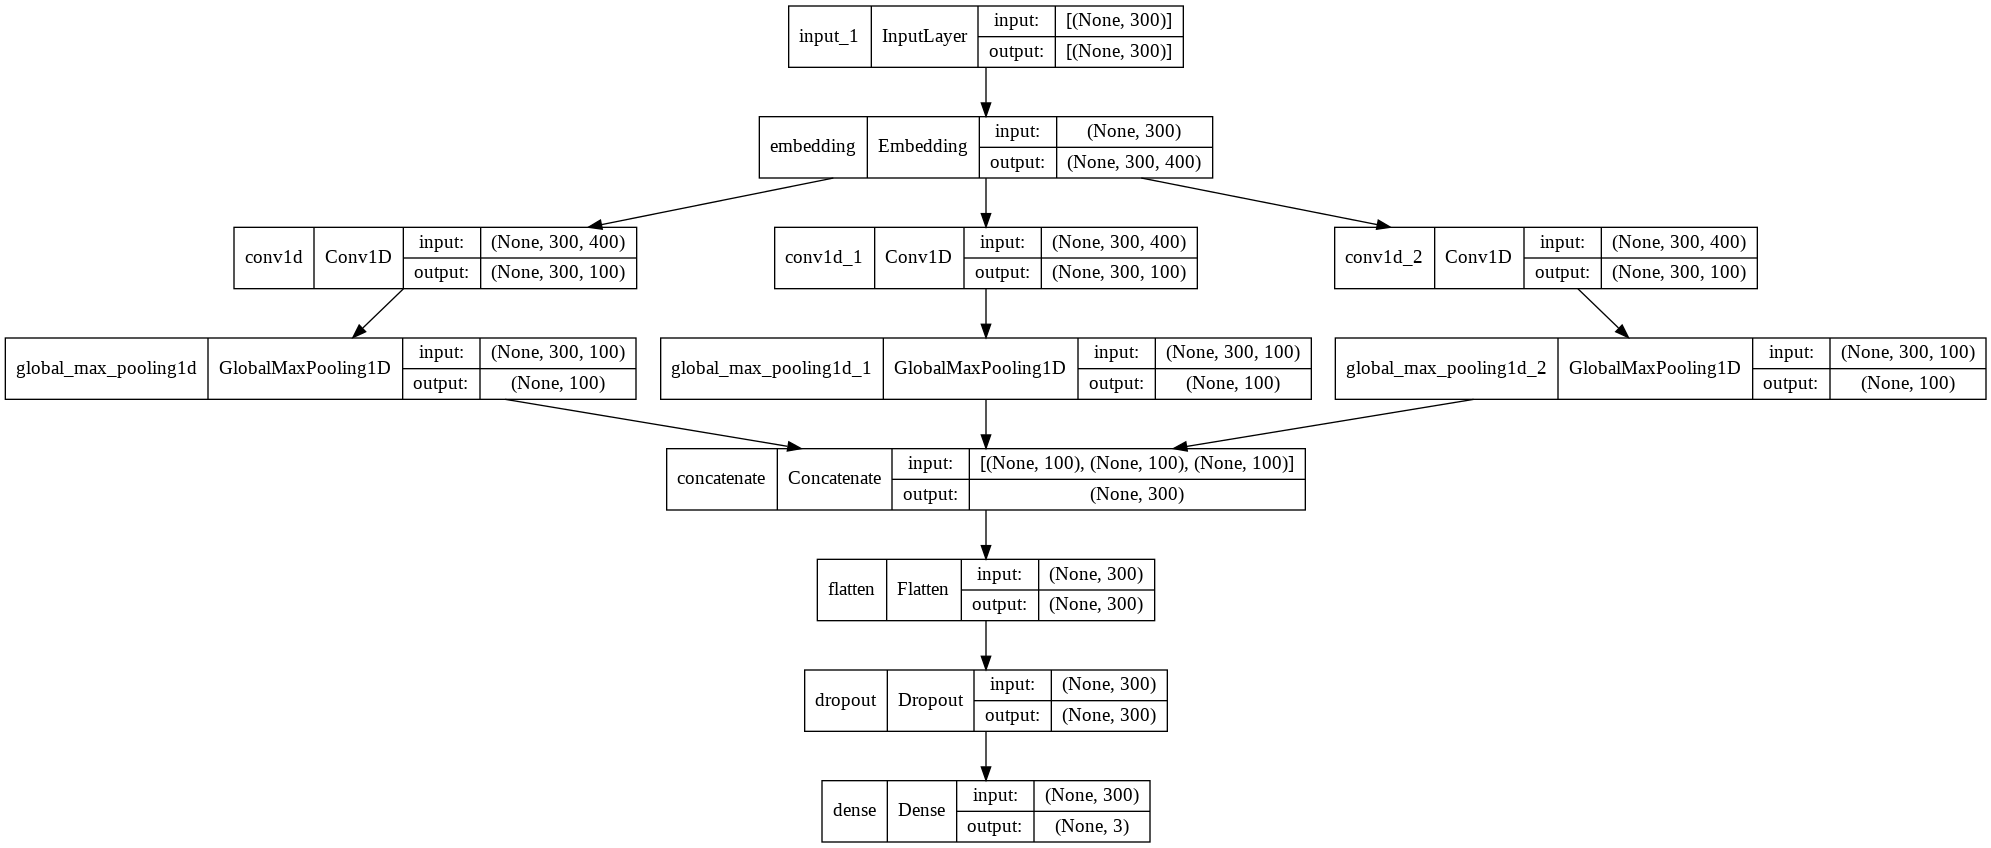

In [ ]:
tf.keras.utils.plot_model(model,to_file='/content/drive/MyDrive/Colab Notebooks/Report/cnn/cnn_300.png',show_shapes=True)

In [ ]:
# from sklearn.model_selection import train_test_split
# X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=302)

In [ ]:
model.fit(data, labels,
          epochs=30, batch_size=256,callbacks=callbacks_list, shuffle=True)

Epoch 1/30
20/20 [==============================] - ETA: 0s - loss: 7.2059 - accuracy: 0.4263
Epoch 00001: loss improved from inf to 7.20594, saving model to /content/drive/MyDrive/Colab Notebooks/Report/cnn/cnn_50.h5
20/20 [==============================] - 6s 162ms/step - loss: 7.2059 - accuracy: 0.4263
Epoch 2/30
19/20 [===========================>..] - ETA: 0s - loss: 5.3104 - accuracy: 0.5870
Epoch 00002: loss improved from 7.20594 to 5.28997, saving model to /content/drive/MyDrive/Colab Notebooks/Report/cnn/cnn_50.h5
20/20 [==============================] - 1s 55ms/step - loss: 5.2900 - accuracy: 0.5880
Epoch 3/30
20/20 [==============================] - ETA: 0s - loss: 4.3031 - accuracy: 0.6908
Epoch 00003: loss improved from 5.28997 to 4.30310, saving model to /content/drive/MyDrive/Colab Notebooks/Report/cnn/cnn_50.h5
20/20 [==============================] - 1s 56ms/step - loss: 4.3031 - accuracy: 0.6908
Epoch 4/30
19/20 [===========================>..] - ETA: 0s - loss: 3.668

In [ ]:
model = tf.keras.models.load_model(file_path)

In [ ]:
score = model.evaluate(datas_test, labels_test)

33/33 [==============================] - 1s 13ms/step - loss: 1.0748 - accuracy: 0.6857


In [ ]:
print("%s: %.2f%%" % (model.metrics_names[0], score[0]*100))
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))


loss: 104.35%
accuracy: 69.43%


###Deep CNN - 68.67%

In [ ]:
from keras.layers import Dense, Input, GlobalMaxPooling1D,BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Conv2D, Dropout,concatenate,Conv1D, MaxPool1D,MaxPooling2D, Bidirectional, LSTM,GRU,SpatialDropout1D
from keras.layers.core import Reshape, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras import regularizers
sequence_length = data.shape[1]

drop = 0.5
inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)

###################### CNN ##############################################

conv_1 = Conv1D(100, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(0.01),activation='relu')(embedding)
maxpool_1 = GlobalMaxPooling1D()(conv_1)


conv_2 = Conv1D(100, kernel_size=4, padding='same', kernel_regularizer=regularizers.l2(0.01),activation='relu')(embedding)
maxpool_2 = GlobalMaxPooling1D()(conv_2)


conv_3 = Conv1D(100, kernel_size=5, padding='same', kernel_regularizer=regularizers.l2(0.01),activation='relu')(embedding)
maxpool_3 = GlobalMaxPooling1D()(conv_3)

conv_4 = Conv1D(100, kernel_size=6, padding='same', kernel_regularizer=regularizers.l2(0.01),activation='relu')(embedding)
maxpool_4 = GlobalMaxPooling1D()(conv_4)

conv_5 = Conv1D(100, kernel_size=7, padding='same', kernel_regularizer=regularizers.l2(0.01),activation='relu')(embedding)
maxpool_5 = GlobalMaxPooling1D()(conv_5)

merged_tensor = concatenate([maxpool_1, maxpool_2,maxpool_3,maxpool_4,maxpool_5])
flatten = Flatten()(merged_tensor)
dropout = Dropout(drop)(flatten)
output = Dense(units=3, activation='softmax')(dropout)


model = Model(inputs, output)


adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

#define callbacks
file_path = '/content/drive/MyDrive/Colab Notebooks/Report/cnn/deepcnn_300.h5'
early_stopping = EarlyStopping(monitor='loss', min_delta=0.1, patience=5, verbose=1)
check_point = ModelCheckpoint(file_path, monitor = "loss", verbose = 1,
                              save_best_only = True, mode = "min")
lrsc = tf.keras.callbacks.LearningRateScheduler(scheduler)
callbacks_list = [early_stopping,check_point]


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 300, 400)     3157600     ['input_8[0][0]']                
                                                                                                  
 conv1d_18 (Conv1D)             (None, 300, 100)     120100      ['embedding_2[0][0]']            
                                                                                                  
 conv1d_19 (Conv1D)             (None, 300, 100)     160100      ['embedding_2[0][0]']            
                                                                                            

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


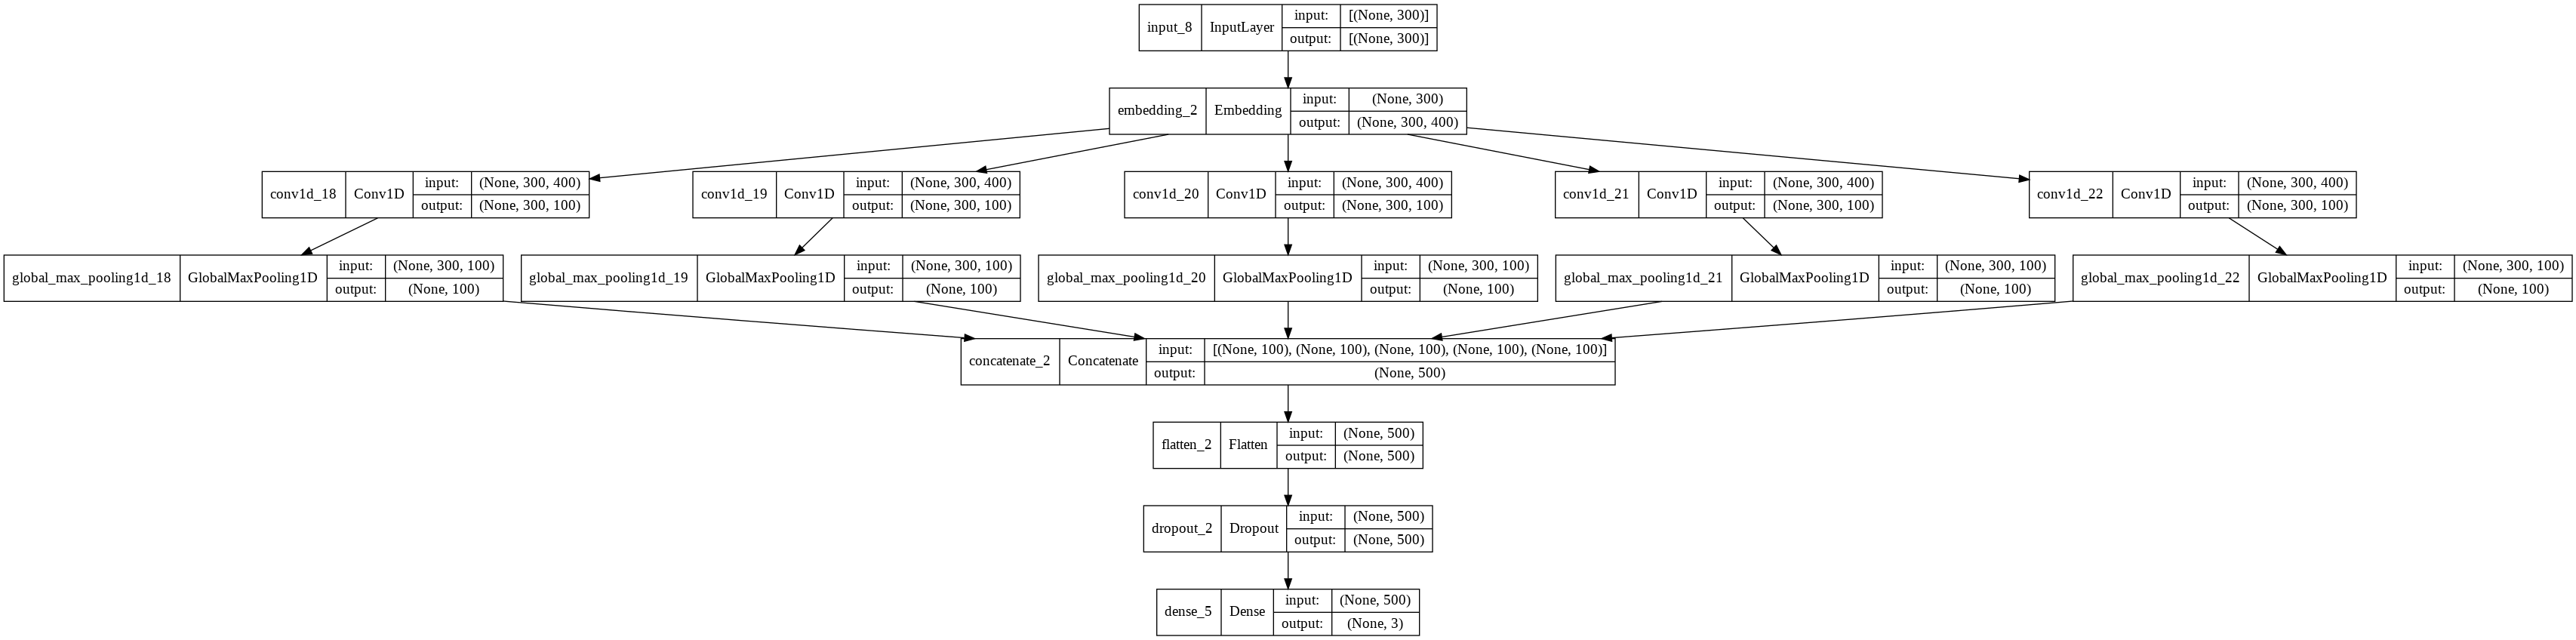

In [ ]:
tf.keras.utils.plot_model(model,to_file='/content/drive/MyDrive/Colab Notebooks/Report/cnn/deepcnn_300.png',show_shapes=True)

In [ ]:
# from sklearn.model_selection import train_test_split
# X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=302)

In [ ]:
model.fit(data, labels,
          epochs=30, batch_size=256,callbacks=callbacks_list, shuffle=True)

Epoch 1/30
20/20 [==============================] - ETA: 0s - loss: 10.9210 - accuracy: 0.4206
Epoch 00001: loss improved from inf to 10.92103, saving model to /content/drive/MyDrive/Colab Notebooks/Report/cnn/cnn_100.h5
20/20 [==============================] - 15s 549ms/step - loss: 10.9210 - accuracy: 0.4206
Epoch 2/30
20/20 [==============================] - ETA: 0s - loss: 7.9121 - accuracy: 0.6220
Epoch 00002: loss improved from 10.92103 to 7.91210, saving model to /content/drive/MyDrive/Colab Notebooks/Report/cnn/cnn_100.h5
20/20 [==============================] - 8s 384ms/step - loss: 7.9121 - accuracy: 0.6220
Epoch 3/30
20/20 [==============================] - ETA: 0s - loss: 6.4588 - accuracy: 0.7214
Epoch 00003: loss improved from 7.91210 to 6.45879, saving model to /content/drive/MyDrive/Colab Notebooks/Report/cnn/cnn_100.h5
20/20 [==============================] - 8s 387ms/step - loss: 6.4588 - accuracy: 0.7214
Epoch 4/30
20/20 [==============================] - ETA: 0s - l

In [ ]:
model = tf.keras.models.load_model(file_path)

In [ ]:
score = model.evaluate(datas_test, labels_test)

33/33 [==============================] - 2s 35ms/step - loss: 1.0594 - accuracy: 0.6867


In [ ]:
print("%s: %.2f%%" % (model.metrics_names[0], score[0]*100))
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))


loss: 105.94%
accuracy: 68.67%


###Deep CNN - Reduce Dim - 69.71%

In [ ]:
from keras.layers import Dense, Input, GlobalMaxPooling1D,BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Conv2D, Dropout,concatenate,Conv1D, MaxPool1D,MaxPooling2D, Bidirectional, LSTM,GRU,SpatialDropout1D
from keras.layers.core import Reshape, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras import regularizers
sequence_length = data.shape[1]

drop = 0.5
inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)

###################### CNN ##############################################

conv_1 = Conv1D(100, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(0.01),activation='relu')(embedding)
maxpool_1 = GlobalMaxPooling1D()(conv_1)


conv_2 = Conv1D(100, kernel_size=4, padding='same', kernel_regularizer=regularizers.l2(0.01),activation='relu')(embedding)
maxpool_2 = GlobalMaxPooling1D()(conv_2)


conv_3 = Conv1D(100, kernel_size=5, padding='same', kernel_regularizer=regularizers.l2(0.01),activation='relu')(embedding)
maxpool_3 = GlobalMaxPooling1D()(conv_3)

conv_4 = Conv1D(100, kernel_size=6, padding='same', kernel_regularizer=regularizers.l2(0.01),activation='relu')(embedding)
maxpool_4 = GlobalMaxPooling1D()(conv_4)

conv_5 = Conv1D(100, kernel_size=7, padding='same', kernel_regularizer=regularizers.l2(0.01),activation='relu')(embedding)
maxpool_5 = GlobalMaxPooling1D()(conv_5)

merged_tensor = concatenate([maxpool_1, maxpool_2,maxpool_3,maxpool_4,maxpool_5])
flatten = Flatten()(merged_tensor)
dropout = Dropout(drop)(flatten)
output = Dense(units=3, activation='softmax')(dropout)


model = Model(inputs, output)


adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

#define callbacks
file_path = '/content/drive/MyDrive/Colab Notebooks/Report/cnn/deepcnn_100.h5'
early_stopping = EarlyStopping(monitor='loss', min_delta=0.1, patience=5, verbose=1)
check_point = ModelCheckpoint(file_path, monitor = "loss", verbose = 1,
                              save_best_only = True, mode = "min")
lrsc = tf.keras.callbacks.LearningRateScheduler(scheduler)
callbacks_list = [early_stopping,check_point]


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 100, 400)     3157600     ['input_9[0][0]']                
                                                                                                  
 conv1d_23 (Conv1D)             (None, 100, 100)     120100      ['embedding_3[0][0]']            
                                                                                                  
 conv1d_24 (Conv1D)             (None, 100, 100)     160100      ['embedding_3[0][0]']            
                                                                                            

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


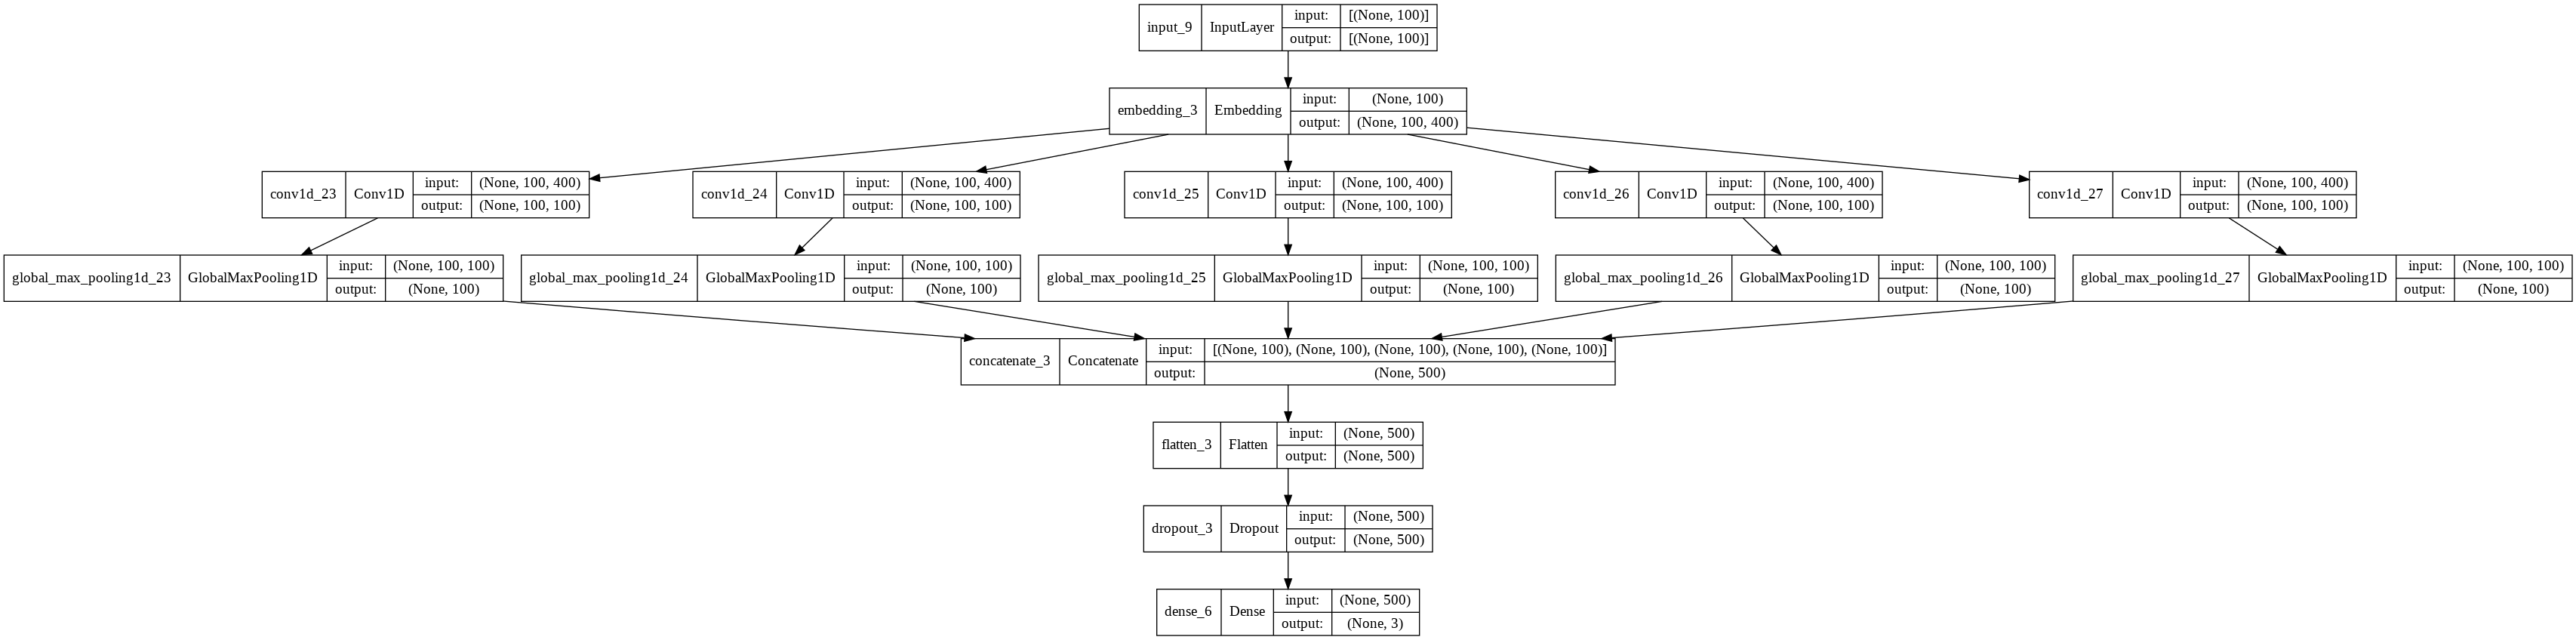

In [ ]:
tf.keras.utils.plot_model(model,to_file='/content/drive/MyDrive/Colab Notebooks/Report/cnn/deepcnn_100.png',show_shapes=True)

In [ ]:
# from sklearn.model_selection import train_test_split
# X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=302)

In [ ]:
model.fit(data, labels,
          epochs=30, batch_size=256,callbacks=callbacks_list, shuffle=True)

Epoch 1/30
20/20 [==============================] - ETA: 0s - loss: 11.0593 - accuracy: 0.4292
Epoch 00001: loss improved from inf to 11.05932, saving model to /content/drive/MyDrive/Colab Notebooks/Report/cnn/deepcnn_100.h5
20/20 [==============================] - 4s 152ms/step - loss: 11.0593 - accuracy: 0.4292
Epoch 2/30
20/20 [==============================] - ETA: 0s - loss: 8.0539 - accuracy: 0.6020
Epoch 00002: loss improved from 11.05932 to 8.05388, saving model to /content/drive/MyDrive/Colab Notebooks/Report/cnn/deepcnn_100.h5
20/20 [==============================] - 3s 144ms/step - loss: 8.0539 - accuracy: 0.6020
Epoch 3/30
20/20 [==============================] - ETA: 0s - loss: 6.5087 - accuracy: 0.7106
Epoch 00003: loss improved from 8.05388 to 6.50874, saving model to /content/drive/MyDrive/Colab Notebooks/Report/cnn/deepcnn_100.h5
20/20 [==============================] - 3s 144ms/step - loss: 6.5087 - accuracy: 0.7106
Epoch 4/30
20/20 [==============================] - 

In [ ]:
model = tf.keras.models.load_model(file_path)

In [ ]:
score = model.evaluate(datas_test, labels_test)

33/33 [==============================] - 1s 13ms/step - loss: 1.0828 - accuracy: 0.6971


In [ ]:
print("%s: %.2f%%" % (model.metrics_names[0], score[0]*100))
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))


loss: 108.28%
accuracy: 69.71%


###LSTM - 69.14%


In [ ]:
from keras.layers import Dense, Input, GlobalMaxPooling1D,BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Conv2D, Dropout,concatenate,Conv1D, MaxPool1D,MaxPooling2D, Bidirectional, LSTM,GRU,SpatialDropout1D
from keras.layers.core import Reshape, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras import regularizers
sequence_length = data.shape[1]

drop = 0.5
inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)

###################### LSTM ##############################################

#spatial_dropout = SpatialDropout1D(0.4)(embedding)
lstm_0 =LSTM(512, dropout=drop,recurrent_dropout=drop)(embedding)
#lstm_0 = LSTM(256, dropout=0.2,recurrent_dropout=0.2)(lstm_0)


output = Dense(units=3, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(lstm_0)


model = Model(inputs, output)


adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

#define callbacks
file_path = '/content/drive/MyDrive/Colab Notebooks/Report/lstm/lstm_300.h5'
early_stopping = EarlyStopping(monitor='loss', min_delta=0.4, patience=5, verbose=1)
check_point = ModelCheckpoint(file_path, monitor = "loss", verbose = 1,
                              save_best_only = True, mode = "min")
lrsc = tf.keras.callbacks.LearningRateScheduler(scheduler)
callbacks_list = [early_stopping,check_point,lrsc]


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding (Embedding)       (None, 300, 400)          3157600   
                                                                 
 lstm (LSTM)                 (None, 512)               1869824   
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 5,028,963
Trainable params: 5,028,963
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


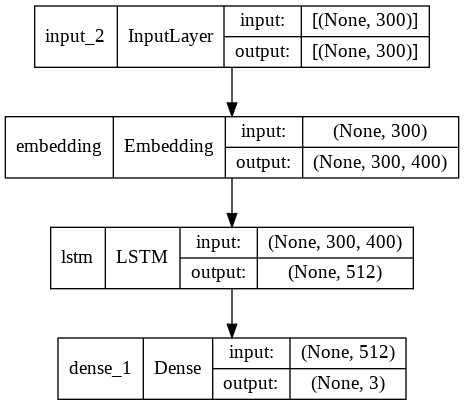

In [ ]:
tf.keras.utils.plot_model(model,to_file='/content/drive/MyDrive/Colab Notebooks/Report/lstm/lstm_300.png',show_shapes=True)

In [ ]:
# from sklearn.model_selection import train_test_split
# X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=302)

In [ ]:
model.fit(data, labels,
          epochs=30, batch_size=256,callbacks=callbacks_list, shuffle=True)

Epoch 1/30
20/20 [==============================] - ETA: 0s - loss: 1.0769 - accuracy: 0.4776
Epoch 00001: loss improved from inf to 1.07694, saving model to /content/drive/MyDrive/Colab Notebooks/Report/lstm/lstm_50.h5
20/20 [==============================] - 12s 452ms/step - loss: 1.0769 - accuracy: 0.4776
Epoch 2/30
20/20 [==============================] - ETA: 0s - loss: 0.8682 - accuracy: 0.6312
Epoch 00002: loss improved from 1.07694 to 0.86816, saving model to /content/drive/MyDrive/Colab Notebooks/Report/lstm/lstm_50.h5
20/20 [==============================] - 9s 450ms/step - loss: 0.8682 - accuracy: 0.6312
Epoch 3/30
20/20 [==============================] - ETA: 0s - loss: 0.7450 - accuracy: 0.7067
Epoch 00003: loss improved from 0.86816 to 0.74497, saving model to /content/drive/MyDrive/Colab Notebooks/Report/lstm/lstm_50.h5
20/20 [==============================] - 10s 501ms/step - loss: 0.7450 - accuracy: 0.7067
Epoch 4/30
20/20 [==============================] - ETA: 0s - l

In [ ]:
model = tf.keras.models.load_model(file_path)

In [ ]:
score = model.evaluate(datas_test, labels_test)

33/33 [==============================] - 2s 46ms/step - loss: 0.9612 - accuracy: 0.6771


In [ ]:
print("%s: %.2f%%" % (model.metrics_names[0], score[0]*100))
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))


loss: 94.31%
accuracy: 69.14%


###BiLSTM + Reduce Dim - 68.57%


In [ ]:
from keras.layers import Dense, Input, GlobalMaxPooling1D,BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Conv2D, Dropout,concatenate,Conv1D, MaxPool1D,MaxPooling2D, Bidirectional, LSTM,GRU,SpatialDropout1D
from keras.layers.core import Reshape, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras import regularizers
sequence_length = data.shape[1]

drop = 0.5
inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)

###################### BiLSTM ##############################################

#spatial_dropout = SpatialDropout1D(0.4)(embedding)
lstm_0 = Bidirectional(LSTM(512, dropout=drop,recurrent_dropout=drop))(embedding)
#lstm_0 = LSTM(256, dropout=0.2,recurrent_dropout=0.2)(lstm_0)


output = Dense(units=3, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(lstm_0)



model = Model(inputs, output)


adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

#define callbacks
file_path = '/content/drive/MyDrive/Colab Notebooks/Report/lstm/bilstm_100.h5'
early_stopping = EarlyStopping(monitor='loss', min_delta=0.5, patience=4, verbose=1)
check_point = ModelCheckpoint(file_path, monitor = "loss", verbose = 1,
                              save_best_only = True, mode = "min")
lrsc = tf.keras.callbacks.LearningRateScheduler(scheduler)
callbacks_list = [early_stopping,check_point]


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 100, 400)          3157600   
                                                                 
 bidirectional_2 (Bidirectio  (None, 1024)             3739648   
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 3)                 3075      
                                                                 
Total params: 6,900,323
Trainable params: 6,900,323
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


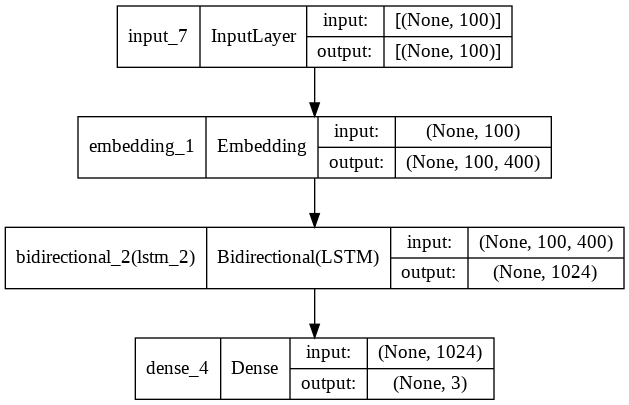

In [ ]:
tf.keras.utils.plot_model(model,to_file='/content/drive/MyDrive/Colab Notebooks/Report/lstm/bilstm_100.png',show_shapes=True)

In [ ]:
# from sklearn.model_selection import train_test_split
# X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=302)

In [ ]:
model.fit(data, labels,
          epochs=30, batch_size=256,callbacks=callbacks_list, shuffle=True)

Epoch 1/30
20/20 [==============================] - ETA: 0s - loss: 1.0607 - accuracy: 0.4882
Epoch 00001: loss improved from inf to 1.06068, saving model to /content/drive/MyDrive/Colab Notebooks/Report/lstm/bilstm_100.h5
20/20 [==============================] - 38s 2s/step - loss: 1.0607 - accuracy: 0.4882
Epoch 2/30
20/20 [==============================] - ETA: 0s - loss: 0.8470 - accuracy: 0.6396
Epoch 00002: loss improved from 1.06068 to 0.84702, saving model to /content/drive/MyDrive/Colab Notebooks/Report/lstm/bilstm_100.h5
20/20 [==============================] - 34s 2s/step - loss: 0.8470 - accuracy: 0.6396
Epoch 3/30
20/20 [==============================] - ETA: 0s - loss: 0.7414 - accuracy: 0.7049
Epoch 00003: loss improved from 0.84702 to 0.74136, saving model to /content/drive/MyDrive/Colab Notebooks/Report/lstm/bilstm_100.h5
20/20 [==============================] - 34s 2s/step - loss: 0.7414 - accuracy: 0.7049
Epoch 4/30
20/20 [==============================] - ETA: 0s - 

In [ ]:
model = tf.keras.models.load_model(file_path)

In [ ]:
score = model.evaluate(datas_test, labels_test)

33/33 [==============================] - 6s 154ms/step - loss: 0.7767 - accuracy: 0.6857


In [ ]:
print("%s: %.2f%%" % (model.metrics_names[0], score[0]*100))
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))


loss: 77.67%
accuracy: 68.57%


###CNN & LSTM - 67.43%

In [ ]:
from keras.layers import Dense, Input, GlobalMaxPooling1D,BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Conv2D, Dropout,concatenate,Conv1D, MaxPool1D,MaxPooling2D, Bidirectional, LSTM,GRU,SpatialDropout1D
from keras.layers.core import Reshape, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras import regularizers
sequence_length = data.shape[1]

drop = 0.5
inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)

###################### CNN ##############################################

conv_1 = Conv1D(100, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(0.01),activation='relu')(embedding)
maxpool_1 = GlobalMaxPooling1D()(conv_1)


conv_2 = Conv1D(100, kernel_size=4, padding='same', kernel_regularizer=regularizers.l2(0.01),activation='relu')(embedding)
maxpool_2 = GlobalMaxPooling1D()(conv_2)


conv_3 = Conv1D(100, kernel_size=5, padding='same', kernel_regularizer=regularizers.l2(0.01),activation='relu')(embedding)
maxpool_3 = GlobalMaxPooling1D()(conv_3)


merged_tensor = concatenate([maxpool_1, maxpool_2,maxpool_3])
flatten_cnn = Flatten()(merged_tensor)
cnn_cb = Dense(units=100, activation='relu',kernel_regularizer=regularizers.l2(0.01))(flatten_cnn)

###################### LSTM ##############################################

lstm_1 = LSTM(512,recurrent_dropout=drop,dropout=drop)(embedding)
lstm_cb = Dense(units=100, activation='relu',kernel_regularizer=regularizers.l2(0.01))(lstm_1)

output = concatenate([cnn_cb,lstm_cb])
output = Dropout(drop)(output)
output = Dense(units=3, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(output)


model = Model(inputs, output)


adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

#define callbacks
file_path = '/content/drive/MyDrive/Colab Notebooks/Report/combine/cnn&lstm_300.h5'
early_stopping = EarlyStopping(monitor='loss', min_delta=0.5, patience=5, verbose=1)
check_point = ModelCheckpoint(file_path, monitor = "loss", verbose = 1,
                              save_best_only = True, mode = "min")
lrsc = tf.keras.callbacks.LearningRateScheduler(scheduler)
callbacks_list = [early_stopping,check_point]


Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_31 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 300, 400)     3157600     ['input_31[0][0]']               
                                                                                                  
 conv1d_136 (Conv1D)            (None, 300, 100)     120100      ['embedding_4[6][0]']            
                                                                                                  
 conv1d_137 (Conv1D)            (None, 300, 100)     160100      ['embedding_4[6][0]']            
                                                                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


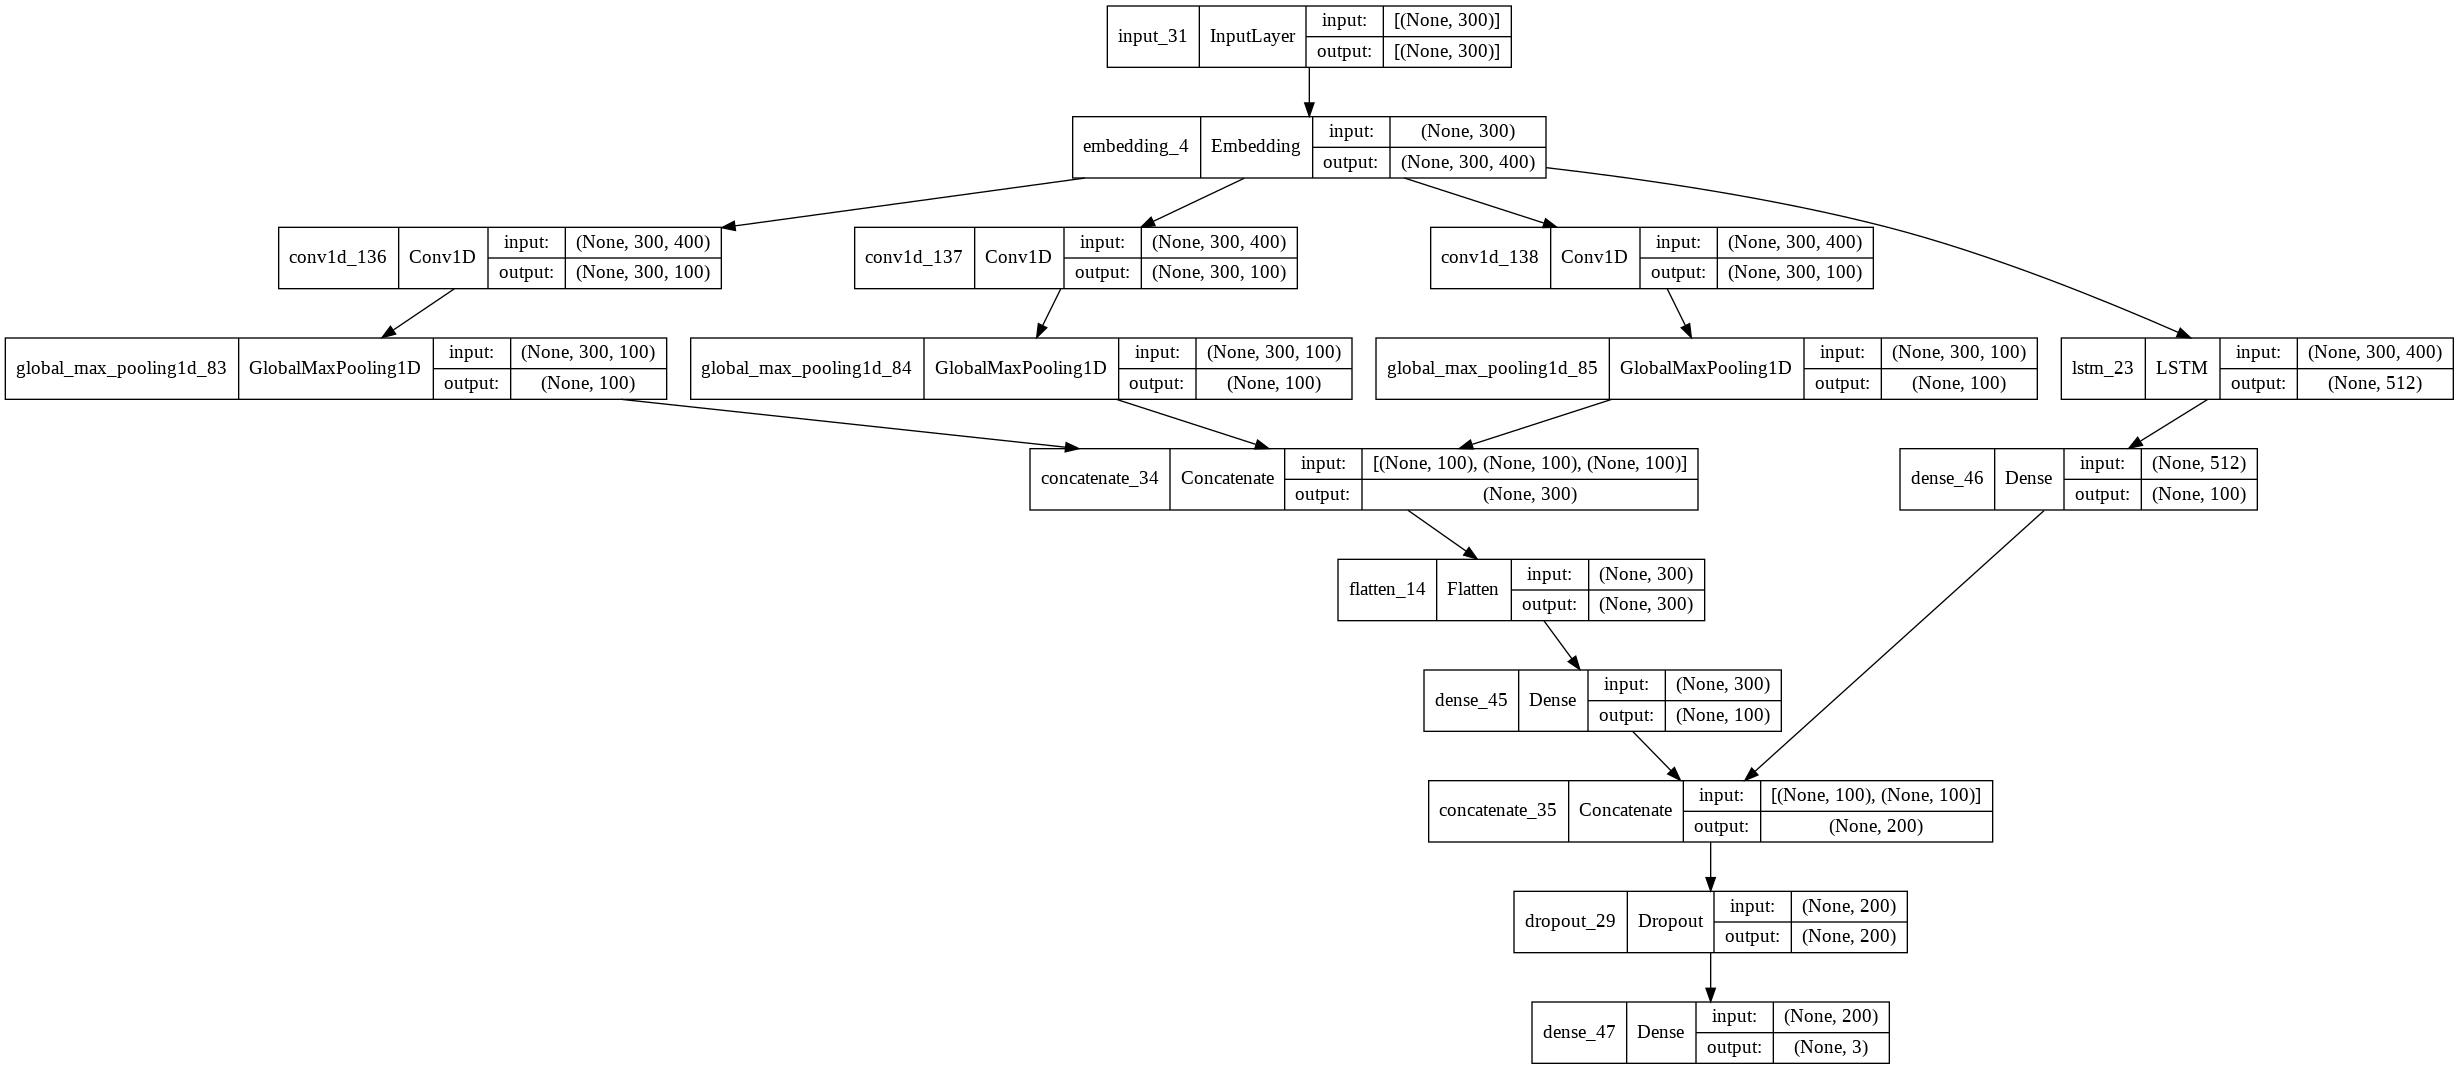

In [ ]:
tf.keras.utils.plot_model(model,to_file='/content/drive/MyDrive/Colab Notebooks/Report/combine/cnn&lstm_300.png',show_shapes=True)

In [ ]:
# from sklearn.model_selection import train_test_split
# X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=302)

In [ ]:
model.fit(data, labels,
          epochs=30, batch_size=256,callbacks=callbacks_list, shuffle=True)

Epoch 1/30
20/20 [==============================] - ETA: 0s - loss: 8.5965 - accuracy: 0.4704
Epoch 00001: loss improved from inf to 8.59654, saving model to /content/drive/MyDrive/Colab Notebooks/Report/combine/cnn&lstm_300.h5
20/20 [==============================] - 54s 3s/step - loss: 8.5965 - accuracy: 0.4704
Epoch 2/30
20/20 [==============================] - ETA: 0s - loss: 6.2906 - accuracy: 0.6725
Epoch 00002: loss improved from 8.59654 to 6.29058, saving model to /content/drive/MyDrive/Colab Notebooks/Report/combine/cnn&lstm_300.h5
20/20 [==============================] - 51s 3s/step - loss: 6.2906 - accuracy: 0.6725
Epoch 3/30
20/20 [==============================] - ETA: 0s - loss: 4.5287 - accuracy: 0.7824
Epoch 00003: loss improved from 6.29058 to 4.52875, saving model to /content/drive/MyDrive/Colab Notebooks/Report/combine/cnn&lstm_300.h5
20/20 [==============================] - 50s 3s/step - loss: 4.5287 - accuracy: 0.7824
Epoch 4/30
20/20 [=============================

In [ ]:
model = tf.keras.models.load_model(file_path)

In [ ]:
score = model.evaluate(datas_test, labels_test)

33/33 [==============================] - 8s 235ms/step - loss: 1.4290 - accuracy: 0.6743


In [ ]:
print("%s: %.2f%%" % (model.metrics_names[0], score[0]*100))
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))


loss: 142.90%
accuracy: 67.43%


###CNN -> LSTM - 66.19%

In [ ]:
from keras.layers import Dense, Input, GlobalMaxPooling1D,BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Conv2D, Dropout,concatenate,Conv1D, MaxPool1D,MaxPooling2D, Bidirectional, LSTM,GRU,SpatialDropout1D
from keras.layers.core import Reshape, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras import regularizers
sequence_length = data.shape[1]

drop = 0.5
inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)

###################### CNN ##############################################

conv_1 = Conv1D(100, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(0.01),activation='relu')(embedding)


conv_2 = Conv1D(100, kernel_size=4, padding='same', kernel_regularizer=regularizers.l2(0.01),activation='relu')(embedding)


conv_3 = Conv1D(100, kernel_size=5, padding='same', kernel_regularizer=regularizers.l2(0.01),activation='relu')(embedding)





merged_tensor = concatenate([conv_1,conv_2,conv_3])

###################### LSTM ##############################################

lstm_1 = LSTM(512,recurrent_dropout=drop,dropout=drop)(merged_tensor)
output = Dropout(drop)(lstm_1)
output = Dense(units=3, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(output)


model = Model(inputs, output)


adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

#define callbacks
file_path = '/content/drive/MyDrive/Colab Notebooks/Report/combine/cnn->lstm_300.h5'
early_stopping = EarlyStopping(monitor='loss', min_delta=0.5, patience=5, verbose=1)
check_point = ModelCheckpoint(file_path, monitor = "loss", verbose = 1,
                              save_best_only = True, mode = "min")
lrsc = tf.keras.callbacks.LearningRateScheduler(scheduler)
callbacks_list = [early_stopping,check_point]


Model: "model_26"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_32 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 300, 400)     3157600     ['input_32[0][0]']               
                                                                                                  
 conv1d_139 (Conv1D)            (None, 300, 100)     120100      ['embedding_4[7][0]']            
                                                                                                  
 conv1d_140 (Conv1D)            (None, 300, 100)     160100      ['embedding_4[7][0]']            
                                                                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


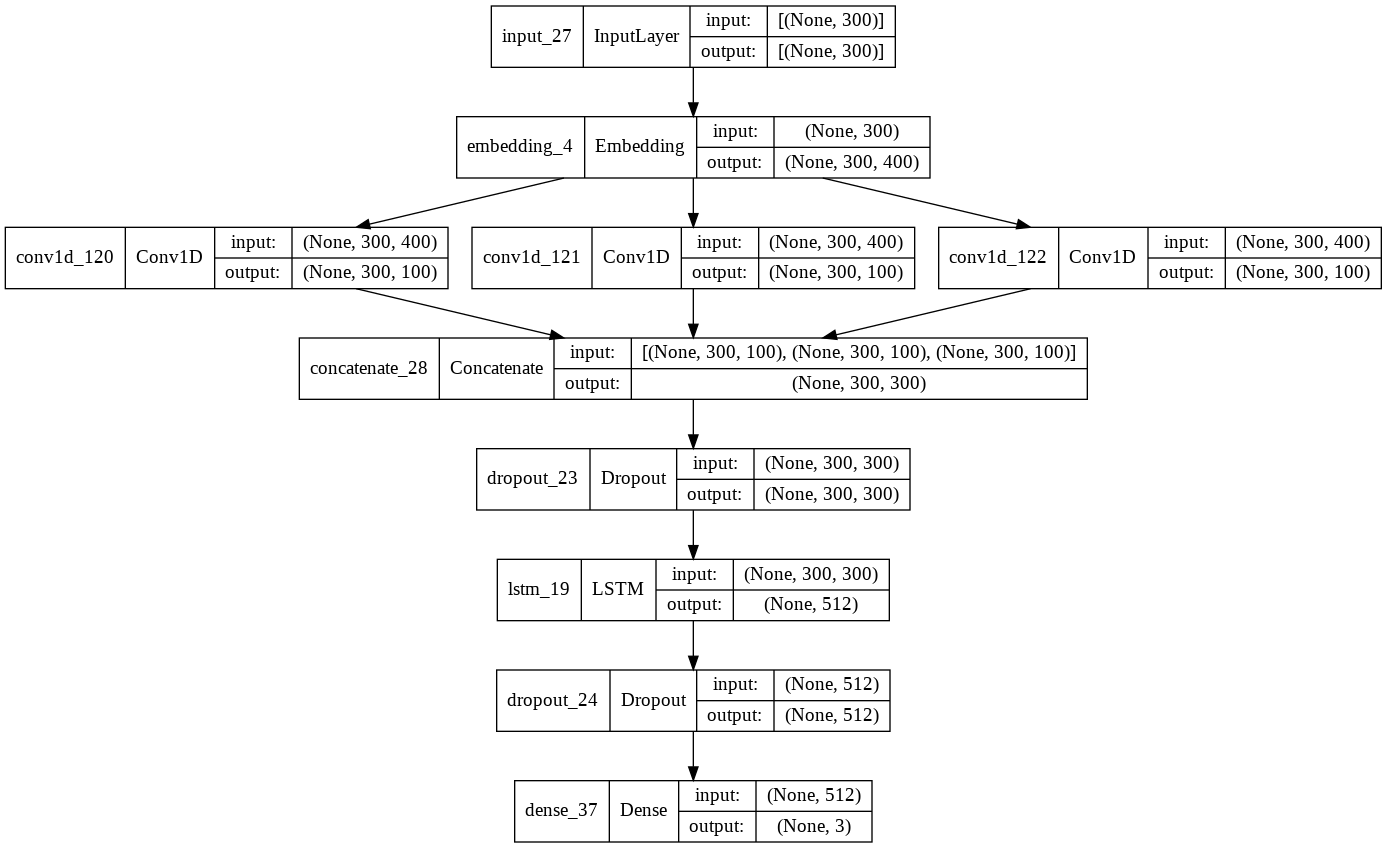

In [ ]:
tf.keras.utils.plot_model(model,to_file='/content/drive/MyDrive/Colab Notebooks/Report/combine/cnn->lstm_300.png',show_shapes=True)

In [ ]:
# from sklearn.model_selection import train_test_split
# X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=302)

In [ ]:
model.fit(data, labels,
          epochs=30, batch_size=256,callbacks=callbacks_list, shuffle=True)

Epoch 1/30
20/20 [==============================] - ETA: 0s - loss: 4.7810 - accuracy: 0.4506
Epoch 00001: loss improved from inf to 4.78101, saving model to /content/drive/MyDrive/Colab Notebooks/Report/combine/cnn->lstm_300.h5
20/20 [==============================] - 54s 3s/step - loss: 4.7810 - accuracy: 0.4506
Epoch 2/30
20/20 [==============================] - ETA: 0s - loss: 2.4487 - accuracy: 0.6996
Epoch 00002: loss improved from 4.78101 to 2.44870, saving model to /content/drive/MyDrive/Colab Notebooks/Report/combine/cnn->lstm_300.h5
20/20 [==============================] - 50s 3s/step - loss: 2.4487 - accuracy: 0.6996
Epoch 3/30
20/20 [==============================] - ETA: 0s - loss: 1.4643 - accuracy: 0.8016
Epoch 00003: loss improved from 2.44870 to 1.46432, saving model to /content/drive/MyDrive/Colab Notebooks/Report/combine/cnn->lstm_300.h5
20/20 [==============================] - 50s 3s/step - loss: 1.4643 - accuracy: 0.8016
Epoch 4/30
20/20 [==========================

In [ ]:
model = tf.keras.models.load_model(file_path)

In [ ]:
score = model.evaluate(datas_test, labels_test)

33/33 [==============================] - 8s 218ms/step - loss: 1.4758 - accuracy: 0.6619


In [ ]:
print("%s: %.2f%%" % (model.metrics_names[0], score[0]*100))
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))


loss: 147.58%
accuracy: 66.19%


###CNN & LSTM - Reduce Dim - 67.90%

In [ ]:
from keras.layers import Dense, Input, GlobalMaxPooling1D,BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Conv2D, Dropout,concatenate,Conv1D, MaxPool1D,MaxPooling2D, Bidirectional, LSTM,GRU,SpatialDropout1D
from keras.layers.core import Reshape, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras import regularizers
sequence_length = data.shape[1]

drop = 0.5
inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)

###################### CNN ##############################################

conv_1 = Conv1D(100, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(0.01),activation='relu')(embedding)
maxpool_1 = GlobalMaxPooling1D()(conv_1)


conv_2 = Conv1D(100, kernel_size=4, padding='same', kernel_regularizer=regularizers.l2(0.01),activation='relu')(embedding)
maxpool_2 = GlobalMaxPooling1D()(conv_2)


conv_3 = Conv1D(100, kernel_size=5, padding='same', kernel_regularizer=regularizers.l2(0.01),activation='relu')(embedding)
maxpool_3 = GlobalMaxPooling1D()(conv_3)

conv_4 = Conv1D(100, kernel_size=6, padding='same', kernel_regularizer=regularizers.l2(0.01),activation='relu')(embedding)
maxpool_4 = GlobalMaxPooling1D()(conv_4)

conv_5 = Conv1D(100, kernel_size=7, padding='same', kernel_regularizer=regularizers.l2(0.01),activation='relu')(embedding)
maxpool_5 = GlobalMaxPooling1D()(conv_5)

merged_tensor = concatenate([maxpool_1, maxpool_2,maxpool_3,maxpool_4,maxpool_5])
flatten_cnn = Flatten()(merged_tensor)
cnn_cb = Dense(units=100, activation='relu',kernel_regularizer=regularizers.l2(0.01))(flatten_cnn)

###################### LSTM ##############################################

lstm_1 = LSTM(512,recurrent_dropout=drop,dropout=drop)(embedding)
lstm_cb = Dense(units=100, activation='relu',kernel_regularizer=regularizers.l2(0.01))(lstm_1)

output = concatenate([cnn_cb,lstm_cb])
output = Dropout(drop)(output)
output = Dense(units=3, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(output)


model = Model(inputs, output)


adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

#define callbacks
file_path = '/content/drive/MyDrive/Colab Notebooks/Report/combine/cnn&lstm_100.h5'
early_stopping = EarlyStopping(monitor='loss', min_delta=0.5, patience=5, verbose=1)
check_point = ModelCheckpoint(file_path, monitor = "loss", verbose = 1,
                              save_best_only = True, mode = "min")
lrsc = tf.keras.callbacks.LearningRateScheduler(scheduler)
callbacks_list = [early_stopping,check_point]


Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 100, 400)     3157600     ['input_18[0][0]']               
                                                                                                  
 conv1d_63 (Conv1D)             (None, 100, 100)     120100      ['embedding_3[9][0]']            
                                                                                                  
 conv1d_64 (Conv1D)             (None, 100, 100)     160100      ['embedding_3[9][0]']            
                                                                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


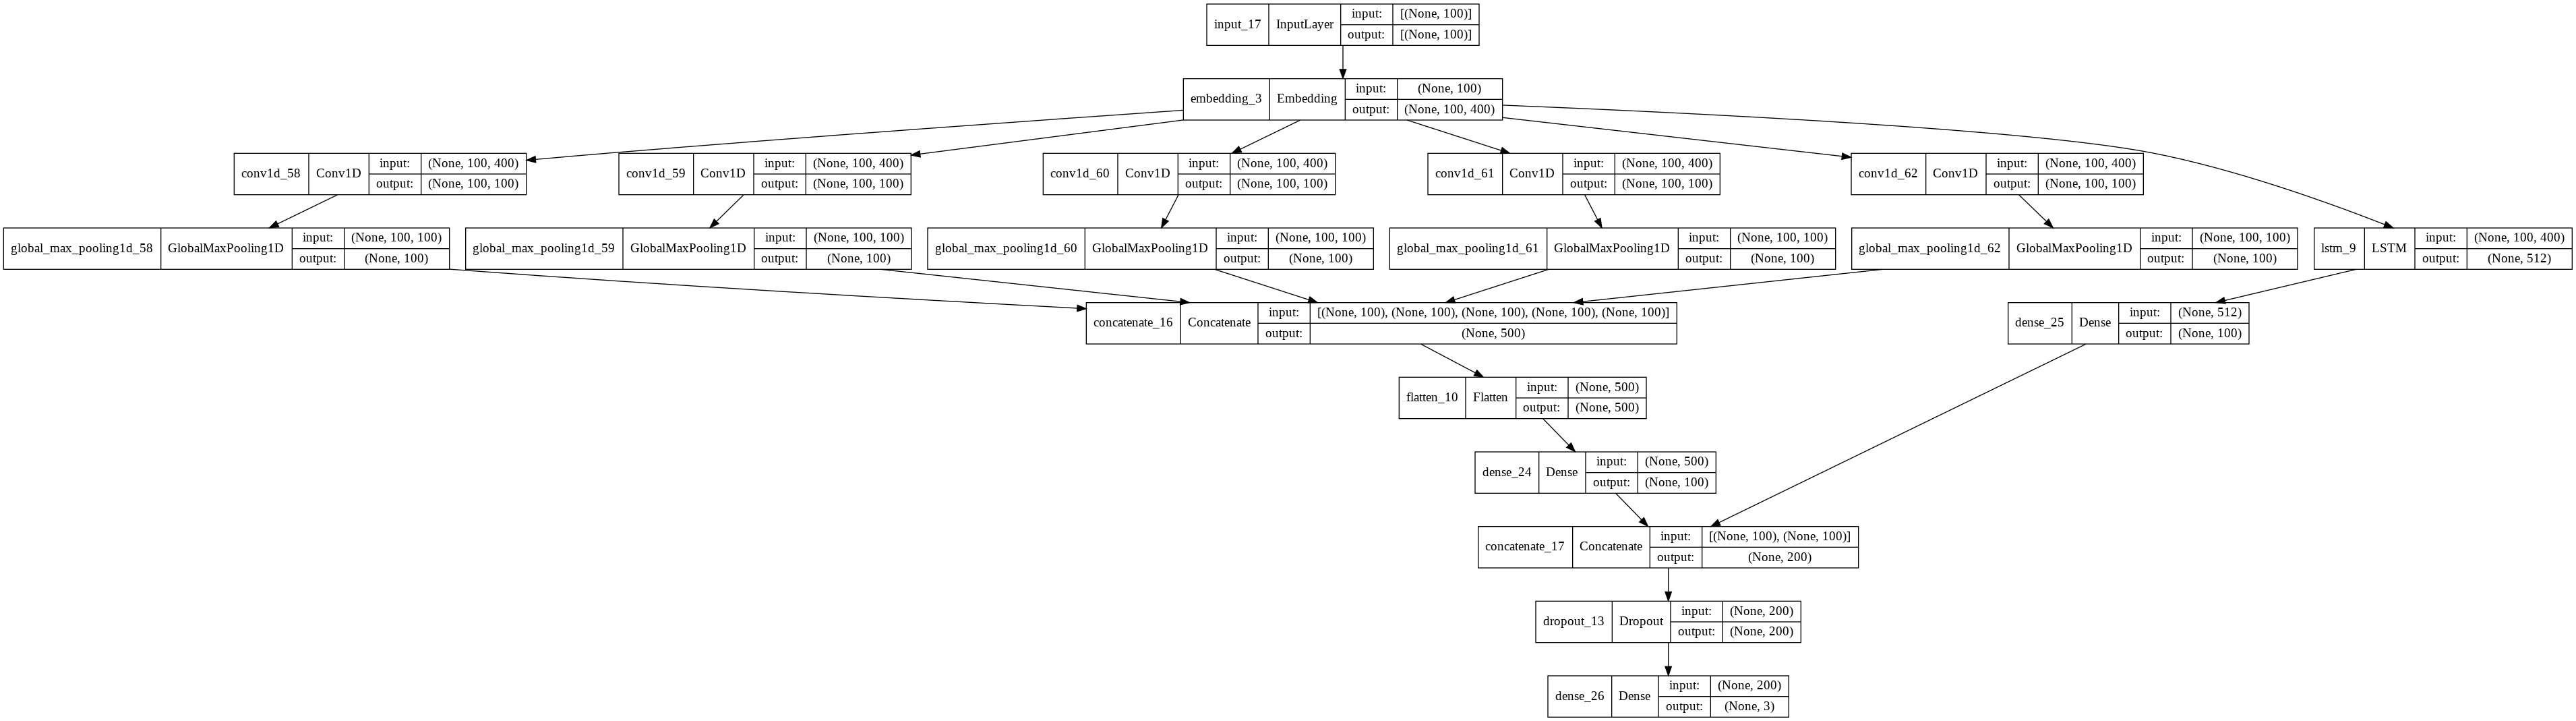

In [ ]:
tf.keras.utils.plot_model(model,to_file='/content/drive/MyDrive/Colab Notebooks/Report/combine/cnn&lstm_100.png',show_shapes=True)

In [ ]:
# from sklearn.model_selection import train_test_split
# X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=302)

In [ ]:
model.fit(data, labels,
          epochs=30, batch_size=256,callbacks=callbacks_list, shuffle=True)

Epoch 1/30
20/20 [==============================] - ETA: 0s - loss: 11.5840 - accuracy: 0.4402
Epoch 00001: loss improved from inf to 11.58397, saving model to /content/drive/MyDrive/Colab Notebooks/Report/combine/cnn&lstm_100.h5
20/20 [==============================] - 23s 942ms/step - loss: 11.5840 - accuracy: 0.4402
Epoch 2/30
20/20 [==============================] - ETA: 0s - loss: 7.8650 - accuracy: 0.6320
Epoch 00002: loss improved from 11.58397 to 7.86495, saving model to /content/drive/MyDrive/Colab Notebooks/Report/combine/cnn&lstm_100.h5
20/20 [==============================] - 20s 1s/step - loss: 7.8650 - accuracy: 0.6320
Epoch 3/30
20/20 [==============================] - ETA: 0s - loss: 5.1804 - accuracy: 0.7235
Epoch 00003: loss improved from 7.86495 to 5.18037, saving model to /content/drive/MyDrive/Colab Notebooks/Report/combine/cnn&lstm_100.h5
20/20 [==============================] - 20s 990ms/step - loss: 5.1804 - accuracy: 0.7235
Epoch 4/30
20/20 [===================

In [ ]:
model = tf.keras.models.load_model(file_path)

In [ ]:
score = model.evaluate(datas_test, labels_test)

33/33 [==============================] - 3s 88ms/step - loss: 1.4519 - accuracy: 0.6790


In [ ]:
print("%s: %.2f%%" % (model.metrics_names[0], score[0]*100))
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))


loss: 145.19%
accuracy: 67.90%


###CNN -> LSTM - Reduce Dim - 64.95%

In [ ]:
from keras.layers import Dense, Input, GlobalMaxPooling1D,BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Conv2D, Dropout,concatenate,Conv1D, MaxPool1D,MaxPooling2D, Bidirectional, LSTM,GRU,SpatialDropout1D
from keras.layers.core import Reshape, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras import regularizers
sequence_length = data.shape[1]

drop = 0.5
inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)

###################### CNN ##############################################

conv_1 = Conv1D(100, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(0.01),activation='relu')(embedding)


conv_2 = Conv1D(100, kernel_size=4, padding='same', kernel_regularizer=regularizers.l2(0.01),activation='relu')(embedding)


conv_3 = Conv1D(100, kernel_size=5, padding='same', kernel_regularizer=regularizers.l2(0.01),activation='relu')(embedding)





merged_tensor = concatenate([conv_1,conv_2,conv_3])

###################### LSTM ##############################################

lstm_1 = LSTM(512,recurrent_dropout=drop,dropout=drop)(merged_tensor)
output = Dropout(drop)(lstm_1)
output = Dense(units=3, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(output)



model = Model(inputs, output)


adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

#define callbacks
file_path = '/content/drive/MyDrive/Colab Notebooks/Report/combine/cnn->lstm_100.h5'
early_stopping = EarlyStopping(monitor='loss', min_delta=0.5, patience=5, verbose=1)
check_point = ModelCheckpoint(file_path, monitor = "loss", verbose = 1,
                              save_best_only = True, mode = "min")
lrsc = tf.keras.callbacks.LearningRateScheduler(scheduler)
callbacks_list = [early_stopping,check_point]


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 400)     3157600     ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 100, 100)     120100      ['embedding[0][0]']              
                                                                                                  
 conv1d_1 (Conv1D)              (None, 100, 100)     160100      ['embedding[0][0]']              
                                                                                              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


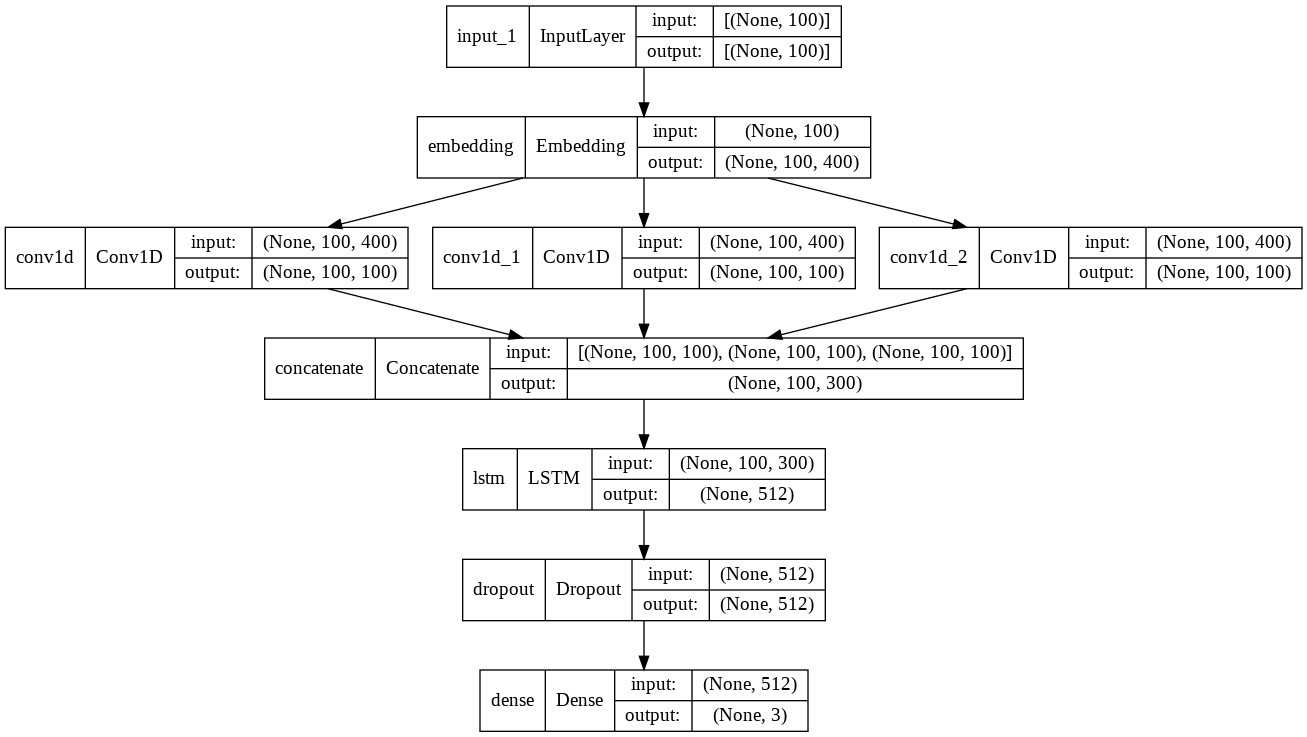

In [ ]:
tf.keras.utils.plot_model(model,to_file='/content/drive/MyDrive/Colab Notebooks/Report/combine/cnn->lstm_100.png',show_shapes=True)

In [ ]:
# from sklearn.model_selection import train_test_split
# X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=302)

In [ ]:
model.fit(data, labels,
          epochs=30, batch_size=256,callbacks=callbacks_list, shuffle=True)

Epoch 1/30
20/20 [==============================] - ETA: 0s - loss: 4.8241 - accuracy: 0.3859
Epoch 00001: loss improved from inf to 4.82411, saving model to /content/drive/MyDrive/Colab Notebooks/Report/combine/cnn->lstm_100.h5
20/20 [==============================] - 31s 941ms/step - loss: 4.8241 - accuracy: 0.3859
Epoch 2/30
20/20 [==============================] - ETA: 0s - loss: 2.6644 - accuracy: 0.4878
Epoch 00002: loss improved from 4.82411 to 2.66440, saving model to /content/drive/MyDrive/Colab Notebooks/Report/combine/cnn->lstm_100.h5
20/20 [==============================] - 18s 924ms/step - loss: 2.6644 - accuracy: 0.4878
Epoch 3/30
20/20 [==============================] - ETA: 0s - loss: 1.7248 - accuracy: 0.5539
Epoch 00003: loss improved from 2.66440 to 1.72481, saving model to /content/drive/MyDrive/Colab Notebooks/Report/combine/cnn->lstm_100.h5
20/20 [==============================] - 19s 929ms/step - loss: 1.7248 - accuracy: 0.5539
Epoch 4/30
20/20 [=================

In [ ]:
model = tf.keras.models.load_model(file_path)

In [ ]:
score = model.evaluate(datas_test, labels_test)

33/33 [==============================] - 3s 82ms/step - loss: 1.1402 - accuracy: 0.6495


In [ ]:
print("%s: %.2f%%" % (model.metrics_names[0], score[0]*100))
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))


loss: 114.02%
accuracy: 64.95%


###LSTM->CNN - Reduce Dim - 68.86%

In [ ]:
from keras.layers import Dense, Input, GlobalMaxPooling1D,BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Conv2D, Dropout,concatenate,Conv1D, MaxPool1D,MaxPooling2D, Bidirectional, LSTM,GRU,SpatialDropout1D
from keras.layers.core import Reshape, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras import regularizers
sequence_length = data.shape[1]

drop = 0.5
inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)

###################### LSTM ##############################################

lstm_1 = LSTM(512,recurrent_dropout=drop,dropout=drop,return_sequences=True)(embedding)
lstm_1 = LSTM(256,recurrent_dropout=drop,dropout=drop,return_sequences=True)(lstm_1)
output = Dropout(drop)(lstm_1)

###################### CNN ##############################################

conv_1 = Conv1D(100, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(0.01),activation='relu')(lstm_1)
maxpool_1 = GlobalMaxPooling1D()(conv_1)

conv_2 = Conv1D(100, kernel_size=4, padding='same', kernel_regularizer=regularizers.l2(0.01),activation='relu')(lstm_1)
maxpool_2 = GlobalMaxPooling1D()(conv_2)

conv_3 = Conv1D(100, kernel_size=5, padding='same', kernel_regularizer=regularizers.l2(0.01),activation='relu')(lstm_1)
maxpool_3 = GlobalMaxPooling1D()(conv_3)




merged_tensor = concatenate([maxpool_1,maxpool_2,maxpool_3])

drop = Dropout(drop)(merged_tensor)
output = Dense(units=3, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(drop)



model = Model(inputs, output)


adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

#define callbacks
file_path = '/content/drive/MyDrive/Colab Notebooks/Report/combine/lstm->cnn_100.h5'
early_stopping = EarlyStopping(monitor='loss', min_delta=0.5, patience=5, verbose=1)
check_point = ModelCheckpoint(file_path, monitor = "loss", verbose = 1,
                              save_best_only = True, mode = "min")
lrsc = tf.keras.callbacks.LearningRateScheduler(scheduler)
callbacks_list = [early_stopping,check_point]


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 400)     3157600     ['input_4[0][0]']                
                                                                                                  
 lstm_5 (LSTM)                  (None, 100, 512)     1869824     ['embedding[3][0]']              
                                                                                                  
 lstm_6 (LSTM)                  (None, 100, 256)     787456      ['lstm_5[0][0]']                 
                                                                                            

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


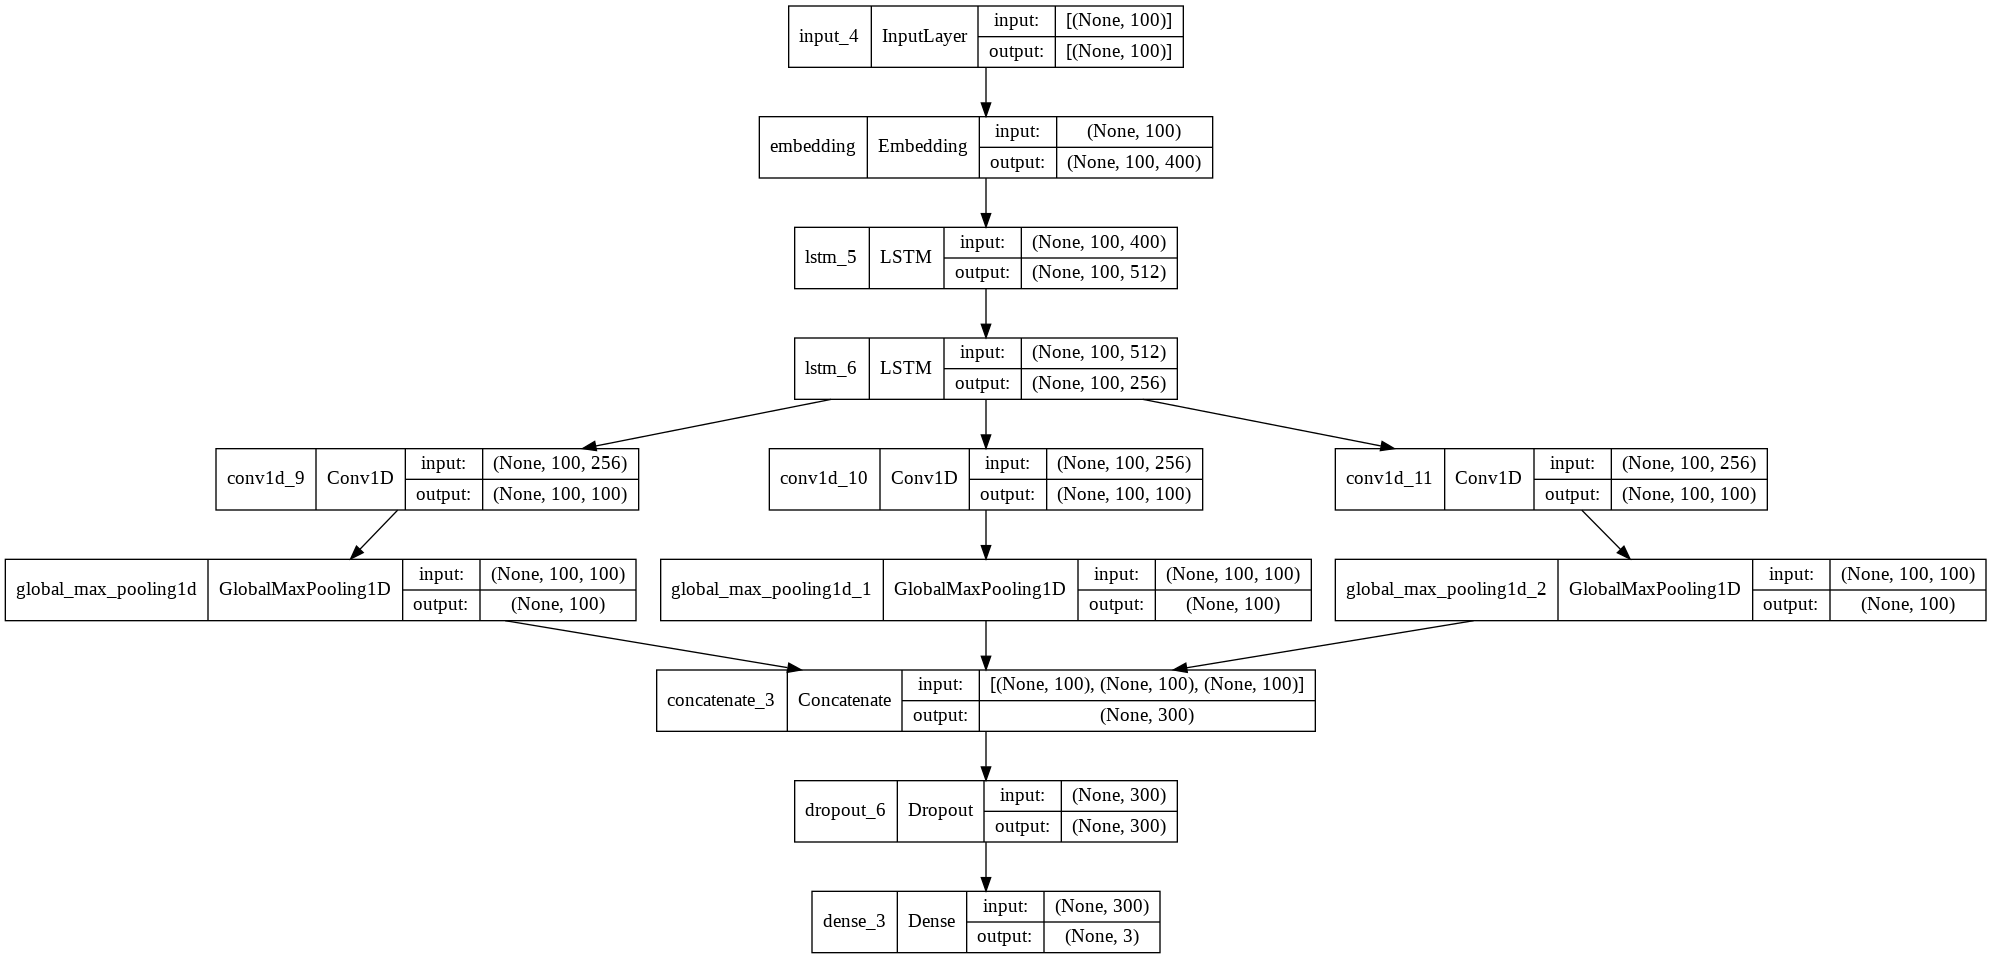

In [ ]:
tf.keras.utils.plot_model(model,to_file='/content/drive/MyDrive/Colab Notebooks/Report/combine/lstm->cnn_100.png',show_shapes=True)

In [ ]:
# from sklearn.model_selection import train_test_split
# X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=302)

In [ ]:
model.fit(data, labels,
          epochs=30, batch_size=256,callbacks=callbacks_list, shuffle=True)

Epoch 1/30
20/20 [==============================] - ETA: 0s - loss: 4.1846 - accuracy: 0.4939
Epoch 00001: loss improved from inf to 4.18465, saving model to /content/drive/MyDrive/Colab Notebooks/Report/combine/lstm->cnn_100.h5
20/20 [==============================] - 40s 2s/step - loss: 4.1846 - accuracy: 0.4939
Epoch 2/30
20/20 [==============================] - ETA: 0s - loss: 2.2695 - accuracy: 0.6384
Epoch 00002: loss improved from 4.18465 to 2.26947, saving model to /content/drive/MyDrive/Colab Notebooks/Report/combine/lstm->cnn_100.h5
20/20 [==============================] - 34s 2s/step - loss: 2.2695 - accuracy: 0.6384
Epoch 3/30
20/20 [==============================] - ETA: 0s - loss: 1.3608 - accuracy: 0.6996
Epoch 00003: loss improved from 2.26947 to 1.36079, saving model to /content/drive/MyDrive/Colab Notebooks/Report/combine/lstm->cnn_100.h5
20/20 [==============================] - 33s 2s/step - loss: 1.3608 - accuracy: 0.6996
Epoch 4/30
20/20 [==========================

In [ ]:
model = tf.keras.models.load_model(file_path)

In [ ]:
score = model.evaluate(datas_test, labels_test)

33/33 [==============================] - 7s 175ms/step - loss: 0.8300 - accuracy: 0.6886


In [ ]:
print("%s: %.2f%%" % (model.metrics_names[0], score[0]*100))
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))


loss: 83.00%
accuracy: 68.86%


###Deep CNN - Reduce Dim - 69.71% - new CBOW - 69.52%

In [ ]:
from keras.layers import Dense, Input, GlobalMaxPooling1D,BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Conv2D, Dropout,concatenate,Conv1D, MaxPool1D,MaxPooling2D, Bidirectional, LSTM,GRU,SpatialDropout1D
from keras.layers.core import Reshape, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras import regularizers
sequence_length = data.shape[1]

drop = 0.5
inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)

###################### CNN ##############################################

conv_1 = Conv1D(100, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(0.01),activation='relu')(embedding)
maxpool_1 = GlobalMaxPooling1D()(conv_1)


conv_2 = Conv1D(100, kernel_size=4, padding='same', kernel_regularizer=regularizers.l2(0.01),activation='relu')(embedding)
maxpool_2 = GlobalMaxPooling1D()(conv_2)


conv_3 = Conv1D(100, kernel_size=5, padding='same', kernel_regularizer=regularizers.l2(0.01),activation='relu')(embedding)
maxpool_3 = GlobalMaxPooling1D()(conv_3)

conv_4 = Conv1D(100, kernel_size=6, padding='same', kernel_regularizer=regularizers.l2(0.01),activation='relu')(embedding)
maxpool_4 = GlobalMaxPooling1D()(conv_4)

conv_5 = Conv1D(100, kernel_size=7, padding='same', kernel_regularizer=regularizers.l2(0.01),activation='relu')(embedding)
maxpool_5 = GlobalMaxPooling1D()(conv_5)

merged_tensor = concatenate([maxpool_1, maxpool_2,maxpool_3,maxpool_4,maxpool_5])
flatten = Flatten()(merged_tensor)
dropout = Dropout(drop)(flatten)
output = Dense(units=3, activation='softmax')(dropout)


model = Model(inputs, output)


adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

#define callbacks
file_path = '/content/drive/MyDrive/Colab Notebooks/Report/newCBOW/deepcnn_100.h5'
early_stopping = EarlyStopping(monitor='loss', min_delta=0.1, patience=5, verbose=1)
check_point = ModelCheckpoint(file_path, monitor = "loss", verbose = 1,
                              save_best_only = True, mode = "min")
lrsc = tf.keras.callbacks.LearningRateScheduler(scheduler)
callbacks_list = [early_stopping,check_point]


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 100, 400)     3157600     ['input_5[0][0]']                
                                                                                                  
 conv1d_12 (Conv1D)             (None, 100, 100)     120100      ['embedding_1[0][0]']            
                                                                                                  
 conv1d_13 (Conv1D)             (None, 100, 100)     160100      ['embedding_1[0][0]']            
                                                                                            

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


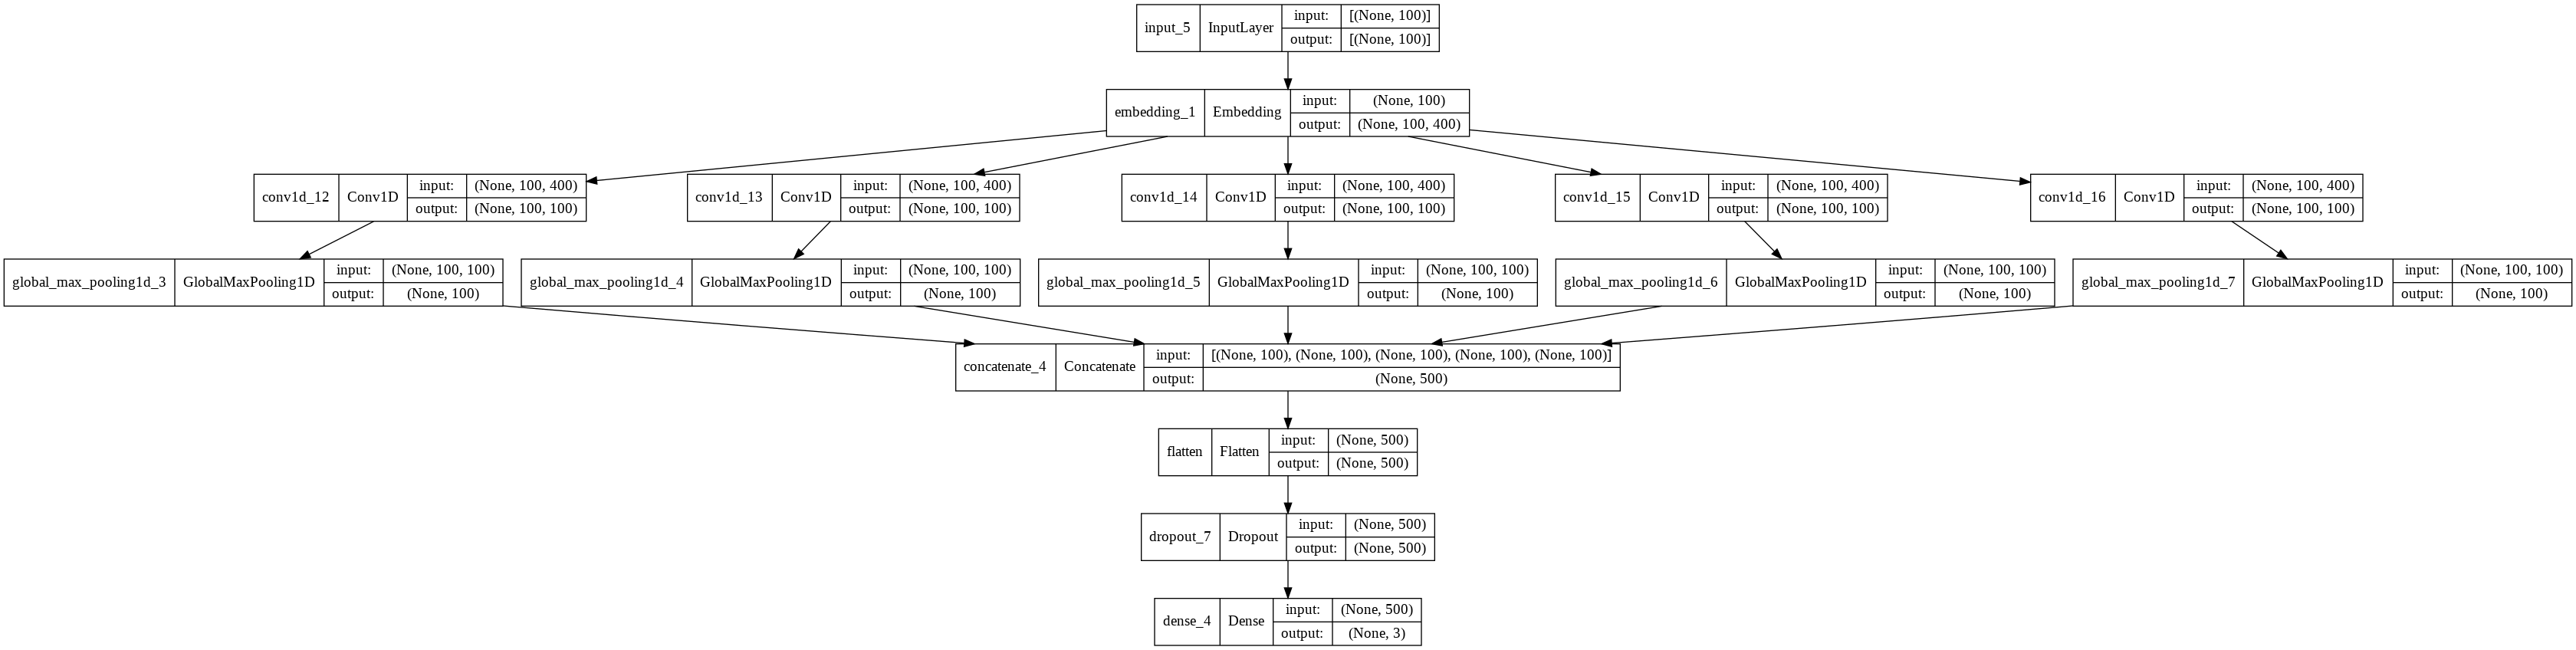

In [ ]:
tf.keras.utils.plot_model(model,to_file='/content/drive/MyDrive/Colab Notebooks/Report/newCBOW/deepcnn_100.png',show_shapes=True)

In [ ]:
# from sklearn.model_selection import train_test_split
# X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=302)

In [ ]:
model.fit(data, labels,
          epochs=30, batch_size=256,callbacks=callbacks_list, shuffle=True)

Epoch 1/30
20/20 [==============================] - ETA: 0s - loss: 11.2041 - accuracy: 0.4541
Epoch 00001: loss improved from inf to 11.20414, saving model to /content/drive/MyDrive/Colab Notebooks/Report/newCBOW/deepcnn_100.h5
20/20 [==============================] - 6s 181ms/step - loss: 11.2041 - accuracy: 0.4541
Epoch 2/30
20/20 [==============================] - ETA: 0s - loss: 8.3453 - accuracy: 0.6608
Epoch 00002: loss improved from 11.20414 to 8.34526, saving model to /content/drive/MyDrive/Colab Notebooks/Report/newCBOW/deepcnn_100.h5
20/20 [==============================] - 3s 153ms/step - loss: 8.3453 - accuracy: 0.6608
Epoch 3/30
20/20 [==============================] - ETA: 0s - loss: 6.8471 - accuracy: 0.7508
Epoch 00003: loss improved from 8.34526 to 6.84713, saving model to /content/drive/MyDrive/Colab Notebooks/Report/newCBOW/deepcnn_100.h5
20/20 [==============================] - 3s 153ms/step - loss: 6.8471 - accuracy: 0.7508
Epoch 4/30
20/20 [======================

In [ ]:
model = tf.keras.models.load_model(file_path)

In [ ]:
score = model.evaluate(datas_test, labels_test)

33/33 [==============================] - 1s 15ms/step - loss: 1.0885 - accuracy: 0.6952


In [ ]:
print("%s: %.2f%%" % (model.metrics_names[0], score[0]*100))
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))


loss: 108.85%
accuracy: 69.52%


###LSTM->CNN - Reduce Dim - 68.86% - new CBOW - 68.48%

In [ ]:
from keras.layers import Dense, Input, GlobalMaxPooling1D,BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Conv2D, Dropout,concatenate,Conv1D, MaxPool1D,MaxPooling2D, Bidirectional, LSTM,GRU,SpatialDropout1D
from keras.layers.core import Reshape, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras import regularizers
sequence_length = data.shape[1]

drop = 0.5
inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)

###################### LSTM ##############################################

lstm_1 = LSTM(512,recurrent_dropout=drop,dropout=drop,return_sequences=True)(embedding)
lstm_1 = LSTM(256,recurrent_dropout=drop,dropout=drop,return_sequences=True)(lstm_1)
output = Dropout(drop)(lstm_1)

###################### CNN ##############################################

conv_1 = Conv1D(100, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(0.01),activation='relu')(lstm_1)
maxpool_1 = GlobalMaxPooling1D()(conv_1)

conv_2 = Conv1D(100, kernel_size=4, padding='same', kernel_regularizer=regularizers.l2(0.01),activation='relu')(lstm_1)
maxpool_2 = GlobalMaxPooling1D()(conv_2)

conv_3 = Conv1D(100, kernel_size=5, padding='same', kernel_regularizer=regularizers.l2(0.01),activation='relu')(lstm_1)
maxpool_3 = GlobalMaxPooling1D()(conv_3)




merged_tensor = concatenate([maxpool_1,maxpool_2,maxpool_3])

drop = Dropout(drop)(merged_tensor)
output = Dense(units=3, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(drop)



model = Model(inputs, output)


adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

#define callbacks
file_path = '/content/drive/MyDrive/Colab Notebooks/Report/newCBOW/lstm->cnn_100.h5'
early_stopping = EarlyStopping(monitor='loss', min_delta=0.5, patience=5, verbose=1)
check_point = ModelCheckpoint(file_path, monitor = "loss", verbose = 1,
                              save_best_only = True, mode = "min")
lrsc = tf.keras.callbacks.LearningRateScheduler(scheduler)
callbacks_list = [early_stopping,check_point]


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 100, 400)     3157600     ['input_6[0][0]']                
                                                                                                  
 lstm_7 (LSTM)                  (None, 100, 512)     1869824     ['embedding_1[1][0]']            
                                                                                                  
 lstm_8 (LSTM)                  (None, 100, 256)     787456      ['lstm_7[0][0]']                 
                                                                                            

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


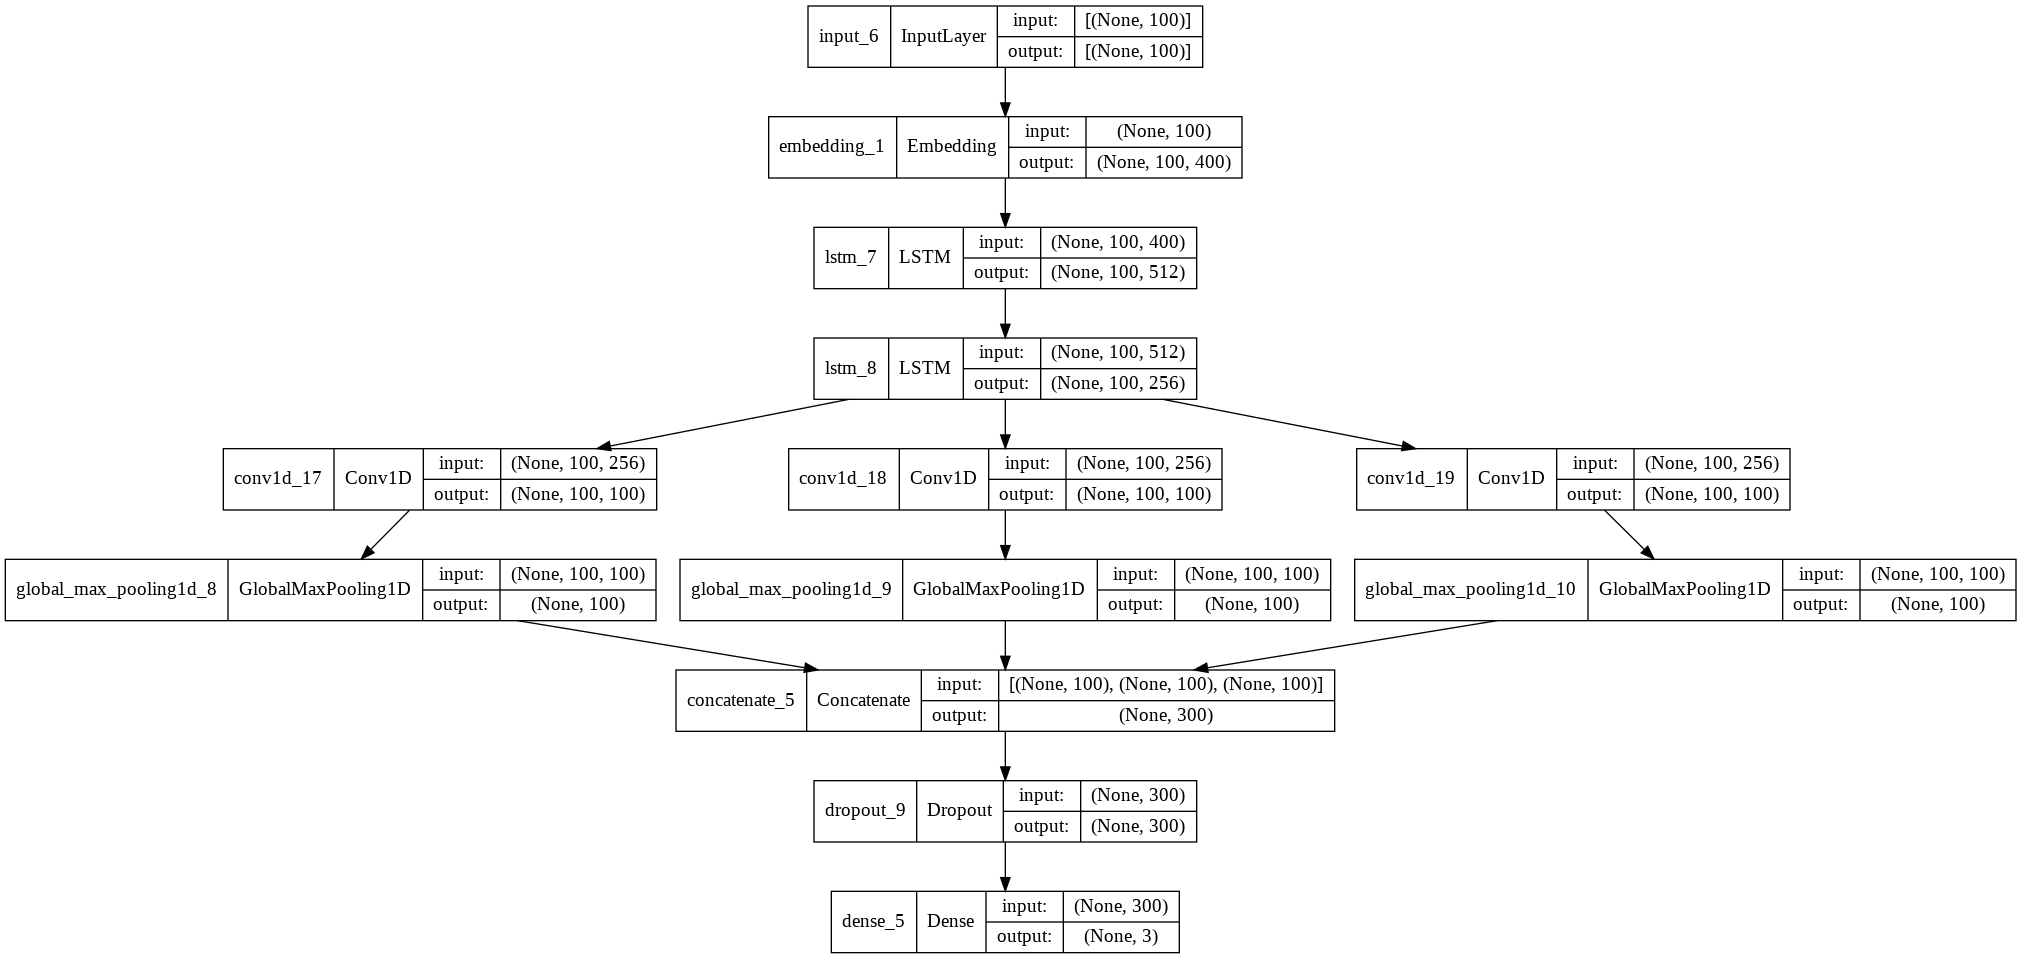

In [ ]:
tf.keras.utils.plot_model(model,to_file='/content/drive/MyDrive/Colab Notebooks/Report/newCBOW/lstm->cnn_100.png',show_shapes=True)

In [ ]:
# from sklearn.model_selection import train_test_split
# X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=302)

In [ ]:
model.fit(data, labels,
          epochs=30, batch_size=256,callbacks=callbacks_list, shuffle=True)

Epoch 1/30
20/20 [==============================] - ETA: 0s - loss: 4.2781 - accuracy: 0.4720
Epoch 00001: loss improved from inf to 4.27813, saving model to /content/drive/MyDrive/Colab Notebooks/Report/newCBOW/lstm->cnn_100.h5
20/20 [==============================] - 39s 2s/step - loss: 4.2781 - accuracy: 0.4720
Epoch 2/30
20/20 [==============================] - ETA: 0s - loss: 2.3555 - accuracy: 0.6269
Epoch 00002: loss improved from 4.27813 to 2.35553, saving model to /content/drive/MyDrive/Colab Notebooks/Report/newCBOW/lstm->cnn_100.h5
20/20 [==============================] - 34s 2s/step - loss: 2.3555 - accuracy: 0.6269
Epoch 3/30
20/20 [==============================] - ETA: 0s - loss: 1.4134 - accuracy: 0.6767
Epoch 00003: loss improved from 2.35553 to 1.41343, saving model to /content/drive/MyDrive/Colab Notebooks/Report/newCBOW/lstm->cnn_100.h5
20/20 [==============================] - 33s 2s/step - loss: 1.4134 - accuracy: 0.6767
Epoch 4/30
20/20 [==========================

In [ ]:
model = tf.keras.models.load_model(file_path)

In [ ]:
score = model.evaluate(datas_test, labels_test)

33/33 [==============================] - 6s 154ms/step - loss: 0.9432 - accuracy: 0.6848


In [ ]:
print("%s: %.2f%%" % (model.metrics_names[0], score[0]*100))
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))


loss: 94.32%
accuracy: 68.48%
